In [1]:
# imports
import os
import math
import dill
from itertools import permutations, combinations

import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression as linreg

import suite2p as s2p

import TwoPUtils
import STX3KO_analyses as stx



%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
basedir_VR = '/home/mplitt/VR_scratch'
figdir_local = '/home/mplitt/Fig_scratch/YMaze/behavior'
figdir_remote = '/STX3_2P_results/YMaze/behavior'

In [17]:

def antic_consum_licks(_sess):
    
    reward_mask = sess.vr_data['reward']._values>0
    reward_start = np.argwhere(reward_mask).ravel()
    reward_end = (reward_start + int(2*sess.scan_info['frame_rate'])).astype(np.int)

    consum_mask = np.zeros(reward_mask.shape)>0
    for (start,end) in zip(reward_start,reward_end):
        consum_mask[start:end]=True

    antic_licks = np.copy(sess.vr_data['lick']._values)
    antic_licks[consum_mask]=0
    
    nonconsum_speed = np.copy(sess.vr_data['dz']._values)
    nonconsum_speed[consum_mask] = np.nan
    
    sess.add_timeseries(antic_licks=antic_licks, 
                        licks = sess.vr_data['lick']._values, 
                        speed = sess.vr_data['dz']._values,
                        antic_speed = nonconsum_speed)
    sess.add_pos_binned_trial_matrix(('antic_licks','speed','antic_speed'),'t',mat_only=True)
    
    
    
    antic_lick_positions = np.zeros(sess.timeseries['licks'].shape)*np.nan
    antic_lick_mask = sess.timeseries['antic_licks']>0
    antic_lick_positions[antic_lick_mask] = sess.vr_data['t']._values[antic_lick_mask.ravel()]
    sess.add_timeseries(antic_lick_positions=antic_lick_positions)
    
def get_probes_and_omissions(sess_):
    
    probes = np.zeros([sess.trial_start_inds.shape[0],])
    omissions = np.zeros([sess.trial_start_inds.shape[0],])
    for trial, (start,stop, lr) in enumerate(zip(sess.trial_start_inds,sess.teleport_inds, sess.trial_info['LR'])):
        if sess.scene in ("YMaze_RewardReversal"):
            lr = np.copy(lr)*-1
        
        pos = sess.vr_data['t'].iloc[start:stop]
        licks = sess.vr_data['lick'].iloc[start:stop]
        reward = sess.vr_data['reward'].iloc[start:stop]
        if lr == 1:
            rzone = (sess.rzone_late['tfront'], sess.rzone_late['tback'])
        else:
            rzone = (sess.rzone_early['tfront'], sess.rzone_early['tback'])
        rzone_mask = (pos>=rzone[0]) & (pos<=rzone[1])
        
        r = reward.sum()
        rzone_licks = licks.loc[rzone_mask].sum()
        if r==0 and rzone_licks>0:
            probes[trial]=1
        elif r==0 and rzone_licks==0:
            omissions[trial]=1
        else:
            pass
        
        sess.trial_info.update({'probes': probes, 'omissions': omissions})
    

def single_trial_lick_metrics(sess):
    
    bin_lower_edges = sess.trial_matrices['bin_edges'][:-1]
    
    lr_early = np.nanmean(sess.trial_matrices['antic_licks'][:,(bin_lower_edges>=sess.rzone_early['t_antic']) & (bin_lower_edges<sess.rzone_early['tfront']+2)], axis=-1)
    lr_early /= np.nanmean(sess.trial_matrices['antic_licks'].ravel())
    lr_late = np.nanmean(sess.trial_matrices['antic_licks'][:,(bin_lower_edges>=sess.rzone_late['t_antic']) & (bin_lower_edges<sess.rzone_late['tfront']+2)], axis=-1)
    lr_late /= np.nanmean(sess.trial_matrices['antic_licks'].ravel())
#     print(lr_early,lr_late)
    lr_d = (lr_early-lr_late)/(lr_early+lr_late+1E-3)
    
    stem_speed = np.nanmean(sess.trial_matrices['antic_speed'][:,sess.trial_matrices['bin_edges'][:-1]<sess.rzone_early['t_antic']].ravel())
    arm_speed = np.nanmean(sess.trial_matrices['antic_speed'][:,sess.trial_matrices['bin_edges'][:-1]>sess.rzone_early['t_antic']],axis=-1)
    arm_speed_norm = arm_speed/stem_speed
    
    
    accuracy = np.zeros([sess.trial_start_inds.shape[0],])
    err = np.zeros([sess.trial_start_inds.shape[0],]) 
    mean = np.zeros([sess.trial_start_inds.shape[0],])*np.nan
    var = np.zeros([sess.trial_start_inds.shape[0],])
    
    for trial, (start,stop, lr,omission) in enumerate(zip(sess.trial_start_inds,sess.teleport_inds, sess.trial_info['LR'],sess.trial_info['omissions'])):
        if omission<1:
            
            
            if sess.scene in ("YMaze_RewardReversal"):
                lr = np.copy(lr)*-1


            pos = sess.vr_data['t'].iloc[start:stop]
            licks = sess.timeseries['antic_licks'][0,start:stop]
            lick_pos = sess.timeseries['antic_lick_positions'][0,start:stop]
            if lr == 1:
                rzone = (sess.rzone_late['t_antic'], sess.rzone_late['tfront']+2)
                tfront = sess.rzone_late['tfront']
                otfront = sess.rzone_early['tfront']
            else:
                rzone = (sess.rzone_early['t_antic'], sess.rzone_early['tfront']+2)
                tfront = sess.rzone_late['tfront']
                otfront = sess.rzone_early['tfront']
            rzone_mask = (pos>=rzone[0]) & (pos<=rzone[1])



            # lick accuracy - fraction of licks in correct reward zone plust 50 cm prior
            accuracy[trial] = licks[rzone_mask].sum()/(licks.sum()+1E-3)
            
            
            # lick position variance
            if licks.sum()>1:
                mean[trial] = np.nanmedian(lick_pos)/tfront
                var[trial] = np.nanstd(lick_pos)
                err[trial] = np.nanmean(np.abs((lick_pos-tfront)/tfront))
            else:
                mean[trial] = np.nansum(lick_pos)/tfront
                var[trial] = 0.
                err[trial] = np.abs(13-tfront)/tfront
    sess.trial_info.update({ 'lickrate_rz_early': lr_early,
                            'lickrate_rz_late': lr_late,
                            'lickrate_dprime': lr_d,
                            'lick_acc': accuracy,
                            'lick_meanpos': mean,
                            'lick_varpos': var,
                            'lick_err': err,
                            'arm_speed': arm_speed,
                            'arm_speed_norm': arm_speed_norm
        
                            })
    
def combine_sessions(trial_info_list):
    
    combined_dict = {}
    for k,v in trial_info_list[0].items():
        combined_dict[k]= [v]

    for i,_dicts in enumerate(trial_info_list[1:]):
        for k,v in _dicts.items():
            if k == 'block_number':
#                 print(trial_info_list[i]['block_number'][-1])
                combined_dict[k].append(v+trial_info_list[i]['block_number'][-1]+1)
            else:
                combined_dict[k].append(v)
            
    for k,v in combined_dict.items():
        combined_dict[k] = np.concatenate(combined_dict[k])

    return combined_dict

def monoexp_decay(x, a, b):
    return a * np.exp(-b * x) 

def monoexp_decay_wint(x,a,b,c):
    return a*np.exp(-b*x) + c

def monoexp_growth_wint(x,a,b,c):
    return (a-c)*(1-np.exp(-b*x)) + c

def line(x, a, b):
    return a*x+b

def monoexp_rise(x,a,b):
    return a*(1-np.exp(-b*x))

def generate_perms(mouse_list0,mouse_list1):
    
    allmice = mouse_list0 +mouse_list1
    perms = []
    for l0 in combinations(allmice,5):
        if not (set(l0)==set(mouse_list0) or set(l0)==set(mouse_list1)):
            l1 = [m for  m in allmice if m not in l0]
            perms.append((l0,l1))
    return perms

def _concat_dicts(d, keys):
    out_d = {}
    for key in keys:
        
        out_d[key] = np.concatenate([val[key] for mouse,val in d.items()])
    return out_d

In [4]:
KO_sessions = {}
keys = ['antic_licks','speed','antic_speed', 'bin_edges']
for mouse, sessions in stx.ymaze_sess_deets.KO_sessions.items():
    print(sessions)
    pkldir = os.path.join('/home/mplitt/YMazeSessPkls/',mouse)
    KO_sessions[mouse] = []
    for deets in sessions:
        print(mouse,deets)
        if isinstance(deets,tuple):
            print('tupe')
            sess_list = []
            for _deets in deets:
                sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,_deets['date'], "%s_%d.pkl" % (_deets['scene'],_deets['session'])),verbose = False)
                antic_consum_licks(sess)
                get_probes_and_omissions(sess)
                single_trial_lick_metrics(sess)
                trial_matrices = {k:sess.trial_matrices[k] for k in keys}
    
                sess_list.append({**_deets, **sess.trial_info, **trial_matrices })
            combined = combine_sessions(sess_list)
            KO_sessions[mouse].append({**combined, 'trial_number': np.arange(combined['LR'].shape[0])})
        else:
            
            sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,deets['date'], "%s_%d.pkl" % (deets['scene'],deets['session'])),verbose = False)
            antic_consum_licks(sess)
            get_probes_and_omissions(sess)
            single_trial_lick_metrics(sess)
            trial_matrices = {k:sess.trial_matrices[k] for k in keys}
            KO_sessions[mouse].append({**deets, **sess.trial_info, **trial_matrices, 'trial_number': np.arange(sess.trial_info['LR'].shape[0]) })
    

            

(({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14}), {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 10}), {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}, ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}))
4467975.1 ({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan'

/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.1 {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.1 {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}
4467975.1 {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.1 {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.1 {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.1 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 10})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.1 {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}
4467975.1 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8}, {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9}, {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}, ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5}), {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}, ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}))
4467975.2 {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}
4467975.2 {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.2 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7}, {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7}, {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6}, ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 6}), {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}, ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}))
4467975.3 {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.3 {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}
4467975.3 {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7}
4467975.3 {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7}
4467975.3 {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.3 {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6}
4467975.3 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 6})
tupe
4467975.3 {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}
4467975.3 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}, {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5}), {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}, ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}))
4467975.4 {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.4 {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.4 {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.4 {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}
4467975.4 {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}
4467975.4 {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}
4467975.4 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.4 {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}
4467975.4 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}, {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7}, {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}, ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 8}), {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}, ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9}))
4467975.5 {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.5 {'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.5 {'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}
4467975.5 {'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7}
4467975.5 {'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467975.5 {'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}
4467975.5 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 8})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467975.5 {'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}
4467975.5 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9})
tupe


In [5]:
CTRL_sessions = {}
for mouse, sessions in stx.ymaze_sess_deets.CTRL_sessions.items():
    print(sessions)
    pkldir = os.path.join('/home/mplitt/YMazeSessPkls/',mouse)
    CTRL_sessions[mouse] = []
    for deets in sessions:
        print(mouse,deets)
        if isinstance(deets,tuple):
            print('tupe')
            sess_list = []
            for _deets in deets:
                sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,_deets['date'], "%s_%d.pkl" % (_deets['scene'],_deets['session'])),verbose = False)
                antic_consum_licks(sess)
                get_probes_and_omissions(sess)
                single_trial_lick_metrics(sess)
                trial_matrices = {k:sess.trial_matrices[k] for k in keys}
                sess_list.append({**_deets, **sess.trial_info,**trial_matrices })
            combined = combine_sessions(sess_list)
            CTRL_sessions[mouse].append({**combined, 'trial_number': np.arange(combined['LR'].shape[0])})
#             CTRL_sessions[mouse].append(combine_sessions(sess_list))
        else:
            
            sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,deets['date'], "%s_%d.pkl" % (deets['scene'],deets['session'])),verbose = False)
            antic_consum_licks(sess)
            get_probes_and_omissions(sess)
            single_trial_lick_metrics(sess)
            trial_matrices = {k:sess.trial_matrices[k] for k in keys}

#             CTRL_sessions[mouse].append({**deets, **sess.trial_info })
            CTRL_sessions[mouse].append({**deets, **sess.trial_info, **trial_matrices, 'trial_number': np.arange(sess.trial_info['LR'].shape[0]) })
    


({'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7}, {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}, {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4}), {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 1}, ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}))
4467331.1 {'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.1 {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.1 {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.1 {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.1 {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.1 {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}
4467331.1 ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.1 {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.1 ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 3}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


({'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, ({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12}), {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4}), {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4}, ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}))
4467331.2 {'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 

/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 ({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467331.2 ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


({'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6}, {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5}), {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 1}, ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}))
4467332.1 {'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.1 ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5})
tupe
(({'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 14}, {'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18}), ({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9}), {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, ({'date': '06_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 6}), {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, '

/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.2 ({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.2 {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}
4467332.2 {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.2 {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467332.2 {'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}
4467332.2 ({'date': '06_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3}, {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 6})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467332.2 {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 2, 'scan': 2}
4467332.2 ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6})
tupe
({'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6}, {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}, {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4}, {'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, ({'date': '06_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5}), {'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, ({'date': '08_12_2020', 'scene': 'YMaze_RewardRevers

/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 {'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 {'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 {'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 ({'date': '06_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2}, {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 5})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 {'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


4467333.1 ({'date': '08_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1, 'scan': 2}, {'date': '08_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4})
tupe


/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)
/home/mplitt/repos/TwoPUtils/TwoPUtils/spatial_analyses.py:65: RuntimeWarning: Mean of empty slice
  trial_mat[trial, b] = np.nanmean(arr_t[(pos_t > edge1) & (pos_t <= edge2), :], axis=0)


In [57]:
mouse = '4467975.5'
deets = stx.ymaze_sess_deets.KO_sessions[mouse][5]
pkldir = os.path.join('/home/mplitt/YMazeSessPkls/',mouse)
sess = stx.session.YMazeSession.from_file(os.path.join(pkldir,deets['date'], "%s_%d.pkl" % (deets['scene'],deets['session'])),verbose = False)
antic_consum_licks(sess)
get_probes_and_omissions(sess)
single_trial_lick_metrics(sess)



In [58]:
sess.rzone_early['t_antic']

27.67690445738824

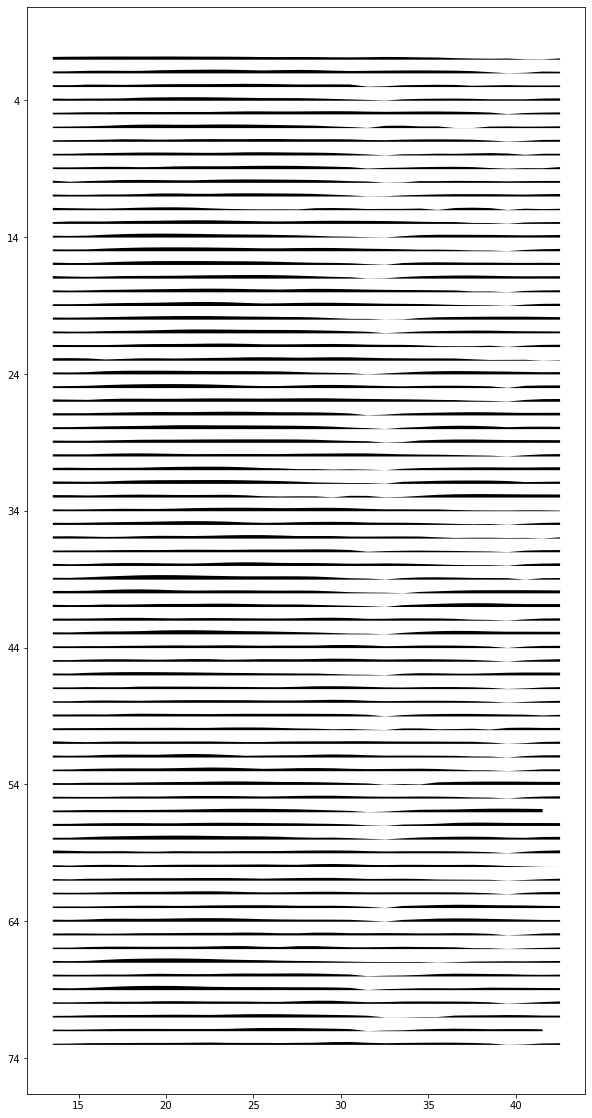

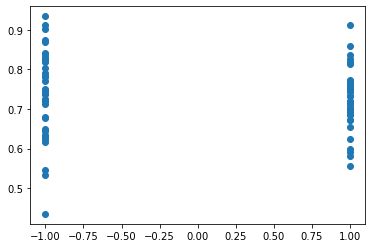

In [59]:
fig,ax = plt.subplots(figsize=[10,20])
TwoPUtils.utilities.smooth_raster(sess.trial_matrices['bin_centers'],sess.trial_matrices['antic_speed'],ax=ax)

stem_speed = sess.trial_matrices['antic_speed'][:,sess.trial_matrices['bin_edges'][:-1]<sess.rzone_early['t_antic']].ravel().mean()
arm_speed = sess.trial_matrices['antic_speed'][:,sess.trial_matrices['bin_edges'][:-1]>sess.rzone_early['t_antic']].mean(axis=-1)
fig,ax = plt.subplots()
ax.scatter(sess.trial_info['LR'],arm_speed/stem_speed)

In [18]:
# licking accuracy vs trial for familiar arm on each day
def monoexp_decay_wint(x,a,b,c):
    return a*np.exp(-b*x) + c

def M0(X, a,b,c):
    # # M0 - n params 3
    return a*np.exp(-b*X[0,:]) + c

def M1(X, a0, a1, b,c):
# # M1 - n params 4
# (a0*groupID + a1*(1-groupID))*np.exp(-b*X[:,0])  + c
    return (a0*X[1,:] +a1*(1-X[1,:]) )*np.exp(-b*X[0,:]) + c

def M2(X, a, b0, b1, c):
# #M2 - n params 4
# a*np.exp(-(b0*groupID + b1*(1-groupID))*X[:,0])  + c
    return a*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c

def M3(X, a0, a1, b0, b1, c):
# #M3 - n params 5
# (a0*groupID + a1*(1-groupID))*np.exp(-(b0*groupID + b1*(1-groupID))*X[:,0])  + c
    return (a0*X[1,:] +a1*(1-X[1,:]) )*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c

def M4(X, a, b, c0, c1):
# #M4 - n params 4
# a*np.exp(-b*X[:,0])  + c0*groupID + c1*(1-groupID)
    return a*np.exp(-b*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])

def M5(X, a0, a1, b, c0, c1):
# #M5 - n params 5
# (a0*groupID + a1*(1-groupID))*np.exp(-b*X[:,0])  + c0*groupID + c1*(1-groupID) 
    return (a0*X[1,:] +a1*(1-X[1,:]))*np.exp(-b*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])

def M6(X, a, b0, b1, c0, c1):
# #M6 - n params 5
# a*np.exp(-(b0*groupID + b1*(1-groupID))*X[:,0])  + c0*groupID + c1*(1-groupID)
    return a*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])

def M7(X, a0, a1, b0, b1, c0, c1):
# #M7 - n params 6
# (a0*groupID + a1*(1-groupID))*np.exp(-(b0*groupID + b1*(1-groupID))*X[:,0])  + c0*groupID + c1*(1-groupID)
    return  (a0*X[1,:] +a1*(1-X[1,:]))*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])

def sample_std(y,yhat,k):
    return np.sqrt(((y-yhat)**2).sum()/(yhat.shape[0]-k))

def log_likelihood(y, yhat, k):
    sigma = sample_std(y,yhat,k)
    likelihood = sp.stats.norm.pdf(y-yhat,loc=0,scale=sigma)
    log_likelihood = np.log10(likelihood).sum()
    return log_likelihood

def bic(y,yhat,k):
    return k*np.log(y.shape[0]) -2.*log_likelihood(y,yhat,k)
    

    

    





In [19]:
def fit_models(X, acc, crossval = False):
        
        bic_vec = []
        popt_list = []
        SSE = []
        dof = []
        
        # baseline
        popt, pcov = curve_fit(M0, X, acc, maxfev=int(1E5), p0= [2,.05,.75], bounds=(-20,20))
        bic_vec.append(bic(acc,M0(X,*popt),3))
        SSE.append(((acc-M0(X, *popt))**2).mean())
        dof.append(acc.shape[0]-3)
        popt_list.append(popt)
        
        # groupwise intercept
        popt, pcov = curve_fit(M1, X, acc, maxfev=int(1E5), p0= [2,2, .05,.75], bounds=(-20,20))
       
        bic_vec.append(bic(acc,M1(X,*popt),5))
        SSE.append(((acc-M1(X, *popt))**2).mean())
        dof.append(acc.shape[0]-5)
        popt_list.append(popt)
        
        # groupwise slope
        popt, pcov = curve_fit(M2, X, acc, maxfev=int(1E5), p0= [2,.05,.05,.75], bounds=(-20,20))
        
        bic_vec.append(bic(acc,M2(X,*popt),5))
        SSE.append(((acc-M2(X, *popt))**2).mean())
        dof.append(acc.shape[0]-5)
        popt_list.append(popt)
       
        # groupwise slope and intercept
        popt, pcov = curve_fit(M3, X, acc, maxfev=int(1E5), p0= [2,2, .05, .05,.75], bounds=(-20,20))
       
        bic_vec.append(bic(acc,M3(X,*popt),6))
        SSE.append(((acc-M3(X, *popt))**2).mean())
        dof.append(acc.shape[0]-6)
        popt_list.append(popt)
        
        # groupwise asymptote
        popt, pcov = curve_fit(M4, X, acc, maxfev=int(1E5), p0= [2,.05,.75, .75], bounds=(-20,20))
        
        bic_vec.append(bic(acc,M4(X,*popt),5))
        SSE.append(((acc-M4(X, *popt))**2).mean())
        dof.append(acc.shape[0]-5)
        popt_list.append(popt)
        
        # groupwise intercept and asymptote
        popt, pcov = curve_fit(M5, X, acc, maxfev=int(1E5), p0= [2,2, .05,.75, .75], bounds=(-20,20))
       
        bic_vec.append(bic(acc,M5(X,*popt),6))
        SSE.append(((acc-M5(X, *popt))**2).mean())
        dof.append(acc.shape[0]-6)
        popt_list.append(popt)
        
        # groupwise slope and asymptote
        popt, pcov = curve_fit(M6, X, acc, maxfev=int(1E5), p0= [2,2, .05,.75, .75], bounds=(-20,20))
       
        bic_vec.append(bic(acc,M6(X,*popt),6))
        SSE.append(((acc-M6(X, *popt))**2).mean())
        dof.append(acc.shape[0]-6)
        popt_list.append(popt)
        
        # groupwise intercept, slope, and asymptote
        popt, pcov = curve_fit(M7, X, acc, maxfev=int(1E5), p0= [2,2, .05, .05,.75, .75], bounds=(-20,20))
        
        bic_vec.append(bic(acc,M7(X,*popt),7))
        SSE.append(((acc-M7(X, *popt))**2).sum())
        dof.append(acc.shape[0]-7)
        popt_list.append(popt)
        
        bic_vec = np.array(bic_vec) - bic_vec[0]
        
        
        if crossval:
            kf = KFold(n_splits = 10, shuffle=True)
            SSE_cv = np.zeros([10,bic_vec.shape[0]])
            for fold, (train,test) in enumerate(kf.split(X.T)):
                X_train, acc_train = X[:,train], acc[train]
                X_test, acc_test = X[:,test], acc[test]
                
                
                # baseline
                popt, pcov = curve_fit(M0, X_train, acc_train, maxfev=int(1E5), p0= [2,.05,.75], bounds=(-20,20))
#                 SSE_cv[fold, 0 ]=((acc_test-M0(X_test, *popt))**2).mean()
                SSE_cv[fold, 0] = log_likelihood(acc, M0(X, *popt), 1).sum()

                # groupwise intercept
                popt, pcov = curve_fit(M1, X_train, acc_train, maxfev=int(1E5), p0= [2,2, .05,.75], bounds=(-20,20))
                SSE_cv[fold, 1] = log_likelihood(acc, M1(X, *popt), 1).sum()
                # groupwise slope
                popt, pcov = curve_fit(M2, X_train, acc_train, maxfev=int(1E5), p0= [2,.05,.05,.75], bounds=(-20,20))
                SSE_cv[fold, 2] = log_likelihood(acc, M2(X, *popt), 1).sum()
                # groupwise slope and intercept
                popt, pcov = curve_fit(M3, X_train, acc_train, maxfev=int(1E5), p0= [2,2, .05, .05,.75], bounds=(-20,20))
                SSE_cv[fold, 3] = log_likelihood(acc, M3(X, *popt), 1).sum()
                # groupwise asymptote
                popt, pcov = curve_fit(M4, X_train, acc_train, maxfev=int(1E5), p0= [2,.05,.75, .75], bounds=(-20,20))
                SSE_cv[fold, 4] = log_likelihood(acc, M4(X, *popt), 1).sum()
                # groupwise intercept and asymptote
                popt, pcov = curve_fit(M5, X_train, acc_train, maxfev=int(1E5), p0= [2,2, .05,.75, .75], bounds=(-20,20))
                SSE_cv[fold, 5] = log_likelihood(acc, M5(X, *popt), 1).sum()
                # groupwise slope and asymptote
                popt, pcov = curve_fit(M6, X_train, acc_train, maxfev=int(1E5), p0= [2,.05, .05,.75, .75], bounds=(-20,20))
                SSE_cv[fold, 6] = log_likelihood(acc, M6(X, *popt), 1).sum()
                # groupwise intercept, slope, and asymptote
                popt, pcov = curve_fit(M7, X_train, acc_train, maxfev=int(1E5), p0= [2,2, .05, .05,.75, .75], bounds=(-20,20))
                SSE_cv[fold, 7] = log_likelihood(acc, M7(X, *popt), 1).sum()
              
              
                
            return bic_vec, np.array(SSE), np.array(dof), popt_list, SSE_cv.sum(axis=0)
        else:
        
            return bic_vec, np.array(SSE), np.array(dof), popt_list

def run_model_comparisons_familiar(KO_sessions,CTRL_sessions,metric):
    
    
    ko_mice = [k for k in KO_sessions.keys()]
    ctrl_mice = [k for k in CTRL_sessions.keys()]
    
    perms = generate_perms(ko_mice,ctrl_mice)
    all_sessions = {**KO_sessions, **CTRL_sessions}
    
    results = []
    fig,ax = plt.subplots()
    for day in range(5):
        
        X = []
        acc = []
        for mouse, d_list in KO_sessions.items():
            d = d_list[day]
            _acc = d[metric][(d['block_number']<5)*(d['probes']==0)*(d['omissions']==0)]
            
            trials = np.arange(_acc.shape[0])
            if mouse=='4467975.4' and day==0:
                mask = np.ones(_acc.shape)>0
                mask[24-5:68-5] = False
                _acc = _acc[mask]
                trials = trials[mask]
            
            acc.append(_acc)
            _x = np.zeros([2,trials.shape[0]])
            _x[0,:] = trials
            
            X.append(_x)
            
        for mouse, d_list in CTRL_sessions.items():
            d = d_list[day]
            _acc = d[metric][(d['block_number']<5)*(d['probes']==0)*(d['omissions']==0)]
            acc.append(_acc)
            trials = np.arange(_acc.shape[0])
            _x = np.ones([2,trials.shape[0]])
            _x[0,:] = trials
            
            X.append(_x)
    
        acc = np.concatenate(acc, axis=-1)
#         print(acc.shape)
        X = np.concatenate(X,axis=-1)
        
        random_order = np.random.permutation(int(acc.shape[0]))
        X = X[:,random_order]
        acc = acc[random_order]
#         print(random_order)
        
        
        print(acc.shape,X.shape)
        
        bic_vec, SSE, dof, popt_list, SSE_cv = fit_models(X, acc, crossval=True)
        print(SSE_cv)
       
                   
        
        ax.plot(bic_vec,color=plt.cm.magma(day/4.))
        print('min bic', np.argmin(bic_vec), 'min bic val', np.amin(bic_vec)-bic_vec[0])
        
        perm_SSE = []
        for p, (l0,l1) in enumerate(perms):
            
            X = []
            acc = []
            
            for mouse, d_list in {mouse:all_sessions[mouse] for mouse in l0}.items():
                d = d_list[day]
                _acc = d[metric][(d['block_number']<5)*(d['probes']==0)*(d['omissions']==0)]
                trials = np.arange(_acc.shape[0])
                
                
                if mouse=='4467975.4' and day==0:
                    mask = np.ones(_acc.shape)>0
                    mask[24-5:68-5] = False
                    _acc = _acc[mask]
                    trials = trials[mask]
                
                acc.append(_acc)
                
                _x = np.zeros([2,trials.shape[0]])
                _x[0,:] = trials

                X.append(_x)

            for mouse, d_list in {mouse:all_sessions[mouse] for mouse in l1}.items():
                d = d_list[day]
                _acc = d[metric][(d['block_number']<5)*(d['probes']==0)*(d['omissions']==0)]
                trials = np.arange(_acc.shape[0])
                if mouse=='4467975.4' and day==0:
                    mask = np.ones(_acc.shape)>0
                    mask[24-5:68-5] = False
                    _acc = _acc[mask]
                    trials = trials[mask]

                acc.append(_acc)
                _x = np.ones([2,trials.shape[0]])
                _x[0,:] = trials

                X.append(_x)
            
            acc = np.concatenate(acc, axis=-1)
            X = np.concatenate(X,axis=-1)
            random_order = np.random.permutation(int(acc.shape[0]))
            X = X[:,random_order]
            acc = acc[random_order]
            
            _bic_vec, _SSE, _dof, _popt_list, _SSE_cv = fit_models(X, acc, crossval=True)
            perm_SSE.append(_SSE_cv)
            
        print(np.array(perm_SSE).shape)
        perm_SSE = np.array(perm_SSE)
        pvec = []
        for col in range(perm_SSE.shape[1]):
            print("Day %d" % day)
            true_SSE = SSE_cv[col]
            _perm_SSE = perm_SSE[:,col]
            p_val = np.float((true_SSE+1E-3<_perm_SSE).sum())/_perm_SSE.shape[0]
            print("M%d, true SSE %f, lowest perm SSE %f, 'p' value %f" % (col, true_SSE, np.amax(_perm_SSE),p_val))
            pvec.append(p_val)
            
            
        results.append({'bic_vec': bic_vec, 'popt_list': popt_list, 'LL_cv': SSE_cv, 'p_val':pvec})
        
    return results
    



def plot_acc_fam(results, metric):
    fig,ax = plt.subplots(1,5,figsize=[25,5], sharey=True)
    for day in range(5):
        
        for mouse, d_list in KO_sessions.items():
            d = d_list[day]
            acc = d[metric][(d['block_number']<5)*(d['probes']==0)]
            trials = np.arange(acc.shape[0])
            
            ax[day].scatter(trials,acc,alpha=.3, color='red')
            
        for mouse, d_list in CTRL_sessions.items():
            d = d_list[day]
            acc = d[metric][(d['block_number']<5)*(d['probes']==0)]
            trials = np.arange(acc.shape[0])
            
            ax[day].scatter(trials,acc,alpha=.3, color='black')
            
            
        LL_cv = results[day]['LL_cv']
        pval = np.array(results[day]['p_val'])
#         ax[day].plot(LL_cv)
        if True:
            # first stage 
            # M0 baseline model
            # M1 groupwise intercept
            # M2 groupwise slope
            # M3 groupwise slope and intercept
            # M4 groupwise asymptote
            # M5 groupwise intercept and asymptote
            # M6 groupwise slope and asymptote
            # M7 groupwise intercept, slope, and asymptote

            onep_inds = [1,2,4]
            onep_LLR = LL_cv[onep_inds] - LL_cv[0]
            onep_pval = pval[onep_inds]

            best_onep_ind = np.argmax(onep_LLR)
            if (onep_pval[best_onep_ind]<.01) and onep_LLR[best_onep_ind]>5:

                if best_onep_ind == 0:
                    twop_inds = [3,5]
                    twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[0]]
                    twop_pval = pval[twop_inds]


                elif best_onep_ind == 1:
                    twop_inds = [3,6]
                    twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[1]]
                    twop_pval = pval[twop_inds]
                elif best_onep_ind == 2:
                    twop_inds = [5,6]
                    twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[2]]
                    twop_pval = pval[twop_inds]
                else:
                    print("onep fail")

                best_twop_ind = np.argmax(twop_LLR)
                if (twop_LLR[best_twop_ind]>5) and (twop_pval[best_twop_ind]<.01):
                    
                    threep_LLR = LL_cv[-1] - LL_cv[twop_inds[best_twop_ind]]
                    if (threep_LLR>5) and (pval[-1]<.05):
                        bestmodel = 7
                    else:
                        bestmodel = twop_inds[best_twop_ind]
                    
                else:
                    bestmodel = onep_inds[best_onep_ind]

            else:
                bestmodel = 0

            X = np.zeros([2,80])
            X[0,:] = np.arange(80)
            m_list = [M0, M1, M2, M3, M4, M5, M6, M7]
            M = m_list[bestmodel]


            if not bestmodel==0:

                ax[day].plot(X[0,:],M(X,*results[day]['popt_list'][bestmodel]),color='red',linewidth=5)

                X[1,:] = 1
                ax[day].plot(X[0,:],M(X,*results[day]['popt_list'][bestmodel]),color='black',linewidth=5)

                ax[day].set_title("best model : %d , p_val %f" % (bestmodel, results[day]['p_val'][bestmodel]))
            else:
                ax[day].plot(X[0,:],M(X,*results[day]['popt_list'][bestmodel]),color='blue',linewidth=5)


    return fig, ax




# change accuracy to squared distance to front of reward zone

# fit models with same or different parameters and calculate AIC, assuming identical variance

# fit exponentioal 


(766,) (2, 766)
[-7269.06668505 -7246.16165198 -7250.23261871 -7244.63392776
 -7238.72155195 -7238.24888246 -7230.26013824 -7230.04771062]
min bic 0 min bic val 0.0
(250, 8)
Day 0
M0, true SSE -7269.066685, lowest perm SSE -7268.713333, 'p' value 0.428000
Day 0
M1, true SSE -7246.161652, lowest perm SSE -7068.039651, 'p' value 0.432000
Day 0
M2, true SSE -7250.232619, lowest perm SSE -7021.958044, 'p' value 0.540000
Day 0
M3, true SSE -7244.633928, lowest perm SSE -7018.241089, 'p' value 0.592000
Day 0
M4, true SSE -7238.721552, lowest perm SSE -7038.962676, 'p' value 0.408000
Day 0
M5, true SSE -7238.248882, lowest perm SSE -7038.511027, 'p' value 0.448000
Day 0
M6, true SSE -7230.260138, lowest perm SSE -7021.110358, 'p' value 0.512000
Day 0
M7, true SSE -7230.047711, lowest perm SSE -7016.966455, 'p' value 0.544000
(774,) (2, 774)
[-6861.99865623 -6808.38323627 -6815.76867421 -6803.23634117
 -6827.00936342 -6792.11066857 -6795.54146823 -6790.97262057]
min bic 0 min bic val 0.0


<ipython-input-6-78599f037e8c>:42: RuntimeWarning: overflow encountered in exp
  return  (a0*X[1,:] +a1*(1-X[1,:]))*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])
<ipython-input-6-78599f037e8c>:22: RuntimeWarning: overflow encountered in exp
  return (a0*X[1,:] +a1*(1-X[1,:]) )*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c
<ipython-input-6-78599f037e8c>:42: RuntimeWarning: overflow encountered in multiply
  return  (a0*X[1,:] +a1*(1-X[1,:]))*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])
<ipython-input-6-78599f037e8c>:37: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])


(250, 8)
Day 1
M0, true SSE -6861.998656, lowest perm SSE -6861.044980, 'p' value 0.164000
Day 1
M1, true SSE -6808.383236, lowest perm SSE -6781.771799, 'p' value 0.040000
Day 1
M2, true SSE -6815.768674, lowest perm SSE -6790.060594, 'p' value 0.032000
Day 1
M3, true SSE -6803.236341, lowest perm SSE -6777.773030, 'p' value 0.072000
Day 1
M4, true SSE -6827.009363, lowest perm SSE -6769.025165, 'p' value 0.156000
Day 1
M5, true SSE -6792.110669, lowest perm SSE -6765.004551, 'p' value 0.064000
Day 1
M6, true SSE -6795.541468, lowest perm SSE -6758.628218, 'p' value 0.048000
Day 1
M7, true SSE -6790.972621, lowest perm SSE -6757.578202, 'p' value 0.064000
(779,) (2, 779)
[-5646.84461221 -5627.01317123 -5637.31051323 -5627.52876591
 -5619.04785079 -5608.09554303 -5619.38150706 -5589.28412281]
min bic 0 min bic val 0.0
(250, 8)
Day 2
M0, true SSE -5646.844612, lowest perm SSE -5645.000638, 'p' value 0.220000
Day 2
M1, true SSE -5627.013171, lowest perm SSE -5456.797136, 'p' value 0.3880

<ipython-input-6-78599f037e8c>:22: RuntimeWarning: overflow encountered in exp
  return (a0*X[1,:] +a1*(1-X[1,:]) )*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c


[-5935.36543976 -5765.19943362 -5773.38169248 -5763.47057204
 -5732.6902236  -5684.24187012 -5717.31804706 -5681.26774608]
min bic 5 min bic val -30.619189573615813


<ipython-input-6-78599f037e8c>:22: RuntimeWarning: overflow encountered in exp
  return (a0*X[1,:] +a1*(1-X[1,:]) )*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c
<ipython-input-6-78599f037e8c>:42: RuntimeWarning: overflow encountered in exp
  return  (a0*X[1,:] +a1*(1-X[1,:]))*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])


(250, 8)
Day 3
M0, true SSE -5935.365440, lowest perm SSE -5934.331607, 'p' value 0.256000
Day 3
M1, true SSE -5765.199434, lowest perm SSE -5805.134326, 'p' value 0.000000
Day 3
M2, true SSE -5773.381692, lowest perm SSE -5790.603100, 'p' value 0.000000
Day 3
M3, true SSE -5763.470572, lowest perm SSE -5791.108575, 'p' value 0.000000
Day 3
M4, true SSE -5732.690224, lowest perm SSE -5761.556708, 'p' value 0.000000
Day 3
M5, true SSE -5684.241870, lowest perm SSE -5750.317790, 'p' value 0.000000
Day 3
M6, true SSE -5717.318047, lowest perm SSE -5757.312598, 'p' value 0.000000
Day 3
M7, true SSE -5681.267746, lowest perm SSE -5749.806810, 'p' value 0.000000
(780,) (2, 780)
[-6638.53697581 -6475.43285491 -6488.52400174 -6475.13541985
 -6484.17982674 -6475.11705062 -6475.13990634 -6475.01451062]
min bic 1 min bic val -19.370892043162257
(250, 8)
Day 4
M0, true SSE -6638.536976, lowest perm SSE -6638.217512, 'p' value 0.416000
Day 4
M1, true SSE -6475.432855, lowest perm SSE -6498.333441, 

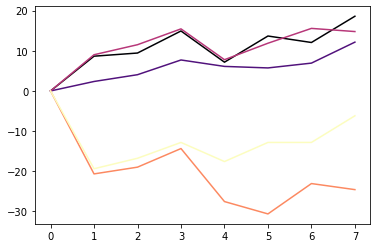

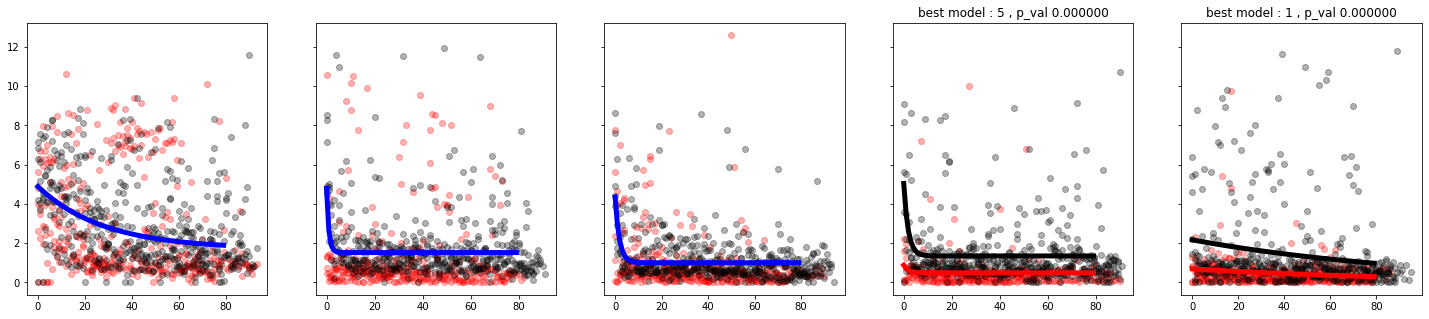

In [9]:
lick_varpos_results_familiar = run_model_comparisons_familiar(KO_sessions,CTRL_sessions, 'lick_varpos')
fig, ax = plot_acc_fam(lick_varpos_results_familiar, 'lick_varpos')

(766,) (2, 766)
[-40.47759286 -40.69710161 -40.75264852 -43.1680474  -40.36130058
 -40.58415236 -43.30114386 -37.85701614]
min bic 0 min bic val 0.0


<ipython-input-6-78599f037e8c>:22: RuntimeWarning: overflow encountered in exp
  return (a0*X[1,:] +a1*(1-X[1,:]) )*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c


(250, 8)
Day 0
M0, true SSE -40.477593, lowest perm SSE -40.015165, 'p' value 0.592000
Day 0
M1, true SSE -40.697102, lowest perm SSE 1306.492726, 'p' value 0.924000
Day 0
M2, true SSE -40.752649, lowest perm SSE 1220.133027, 'p' value 0.968000
Day 0
M3, true SSE -43.168047, lowest perm SSE 1309.426719, 'p' value 0.996000
Day 0
M4, true SSE -40.361301, lowest perm SSE 1335.365094, 'p' value 0.968000
Day 0
M5, true SSE -40.584152, lowest perm SSE 1365.334129, 'p' value 0.976000
Day 0
M6, true SSE -43.301144, lowest perm SSE 1350.376060, 'p' value 0.972000
Day 0
M7, true SSE -37.857016, lowest perm SSE 1354.627608, 'p' value 0.932000
(774,) (2, 774)
[559.37084944 594.91771047 602.04194555 601.7179508  594.73999622
 604.53342834 601.73547851 603.40306358]
min bic 0 min bic val 0.0


<ipython-input-6-78599f037e8c>:37: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])


(250, 8)
Day 1
M0, true SSE 559.370849, lowest perm SSE 560.037802, 'p' value 0.348000
Day 1
M1, true SSE 594.917710, lowest perm SSE 1294.871369, 'p' value 0.700000
Day 1
M2, true SSE 602.041946, lowest perm SSE 1219.279935, 'p' value 0.632000
Day 1
M3, true SSE 601.717951, lowest perm SSE 1313.355880, 'p' value 0.688000
Day 1
M4, true SSE 594.739996, lowest perm SSE 1295.146435, 'p' value 0.680000
Day 1
M5, true SSE 604.533428, lowest perm SSE 1313.344122, 'p' value 0.688000
Day 1
M6, true SSE 601.735479, lowest perm SSE 1313.355110, 'p' value 0.680000
Day 1
M7, true SSE 603.403064, lowest perm SSE 1316.544451, 'p' value 0.684000
(779,) (2, 779)
[1291.38720356 1360.19664645 1382.911021   1365.06593298 1365.81295354
 1382.99177168 1381.98990054 1383.01720106]
min bic 2 min bic val -4.983260978860926


<ipython-input-6-78599f037e8c>:42: RuntimeWarning: overflow encountered in exp
  return  (a0*X[1,:] +a1*(1-X[1,:]))*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])


(250, 8)
Day 2
M0, true SSE 1291.387204, lowest perm SSE 1291.970036, 'p' value 0.708000
Day 2
M1, true SSE 1360.196646, lowest perm SSE 2560.658453, 'p' value 0.528000
Day 2
M2, true SSE 1382.911021, lowest perm SSE 2414.423616, 'p' value 0.464000
Day 2
M3, true SSE 1365.065933, lowest perm SSE 2580.286903, 'p' value 0.548000
Day 2
M4, true SSE 1365.812954, lowest perm SSE 2552.432998, 'p' value 0.520000
Day 2
M5, true SSE 1382.991772, lowest perm SSE 2560.919074, 'p' value 0.528000
Day 2
M6, true SSE 1381.989901, lowest perm SSE 2555.512091, 'p' value 0.520000
Day 2
M7, true SSE 1383.017201, lowest perm SSE 2574.117726, 'p' value 0.528000
(775,) (2, 775)
[1487.47990375 1500.62970366 1522.64712897 1532.771527   1511.82741952
 1535.70188045 1534.67010632 1537.44736891]
min bic 0 min bic val 0.0


<ipython-input-6-78599f037e8c>:22: RuntimeWarning: overflow encountered in exp
  return (a0*X[1,:] +a1*(1-X[1,:]) )*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c
<ipython-input-6-78599f037e8c>:22: RuntimeWarning: overflow encountered in multiply
  return (a0*X[1,:] +a1*(1-X[1,:]) )*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c
<ipython-input-6-78599f037e8c>:42: RuntimeWarning: overflow encountered in exp
  return  (a0*X[1,:] +a1*(1-X[1,:]))*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])


(250, 8)
Day 3
M0, true SSE 1487.479904, lowest perm SSE 1487.865985, 'p' value 0.324000
Day 3
M1, true SSE 1500.629704, lowest perm SSE 2404.601165, 'p' value 0.756000
Day 3
M2, true SSE 1522.647129, lowest perm SSE 2327.442840, 'p' value 0.720000
Day 3
M3, true SSE 1532.771527, lowest perm SSE 2450.934022, 'p' value 0.680000
Day 3
M4, true SSE 1511.827420, lowest perm SSE 2371.144850, 'p' value 0.696000
Day 3
M5, true SSE 1535.701880, lowest perm SSE 2421.928023, 'p' value 0.688000
Day 3
M6, true SSE 1534.670106, lowest perm SSE 2466.156675, 'p' value 0.720000
Day 3
M7, true SSE 1537.447369, lowest perm SSE 2467.062202, 'p' value 0.712000
(780,) (2, 780)
[344.25066536 507.52900447 509.41180315 516.9875509  507.64191727
 516.13070448 516.8985521  517.32133122]
min bic 2 min bic val -19.76099040690218
(250, 8)
Day 4
M0, true SSE 344.250665, lowest perm SSE 344.991265, 'p' value 0.988000
Day 4
M1, true SSE 507.529004, lowest perm SSE 1524.683972, 'p' value 0.344000
Day 4
M2, true SSE 50

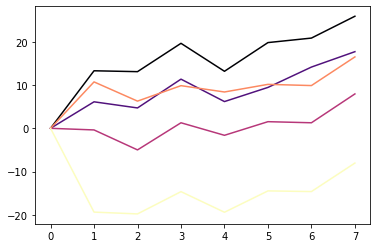

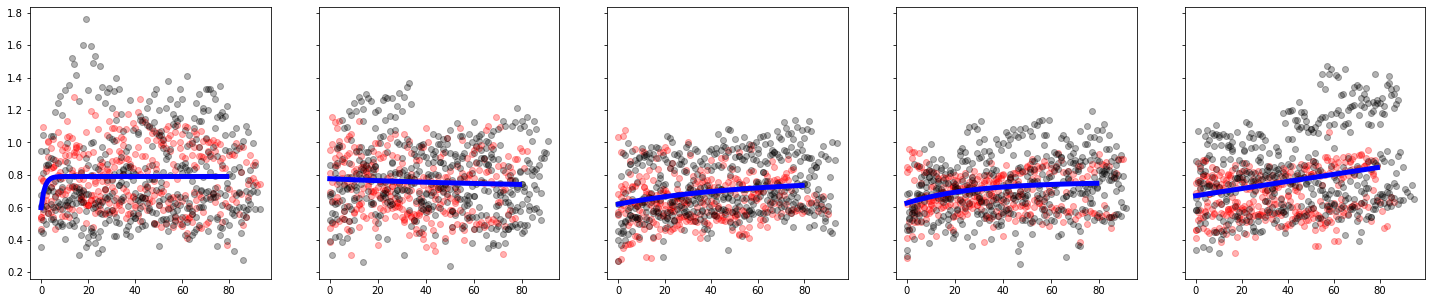

In [10]:
lick_armspeed_norm_results_familiar = run_model_comparisons_familiar(KO_sessions,CTRL_sessions, 'arm_speed_norm')
fig, ax = plot_acc_fam(lick_armspeed_norm_results_familiar, 'arm_speed_norm')

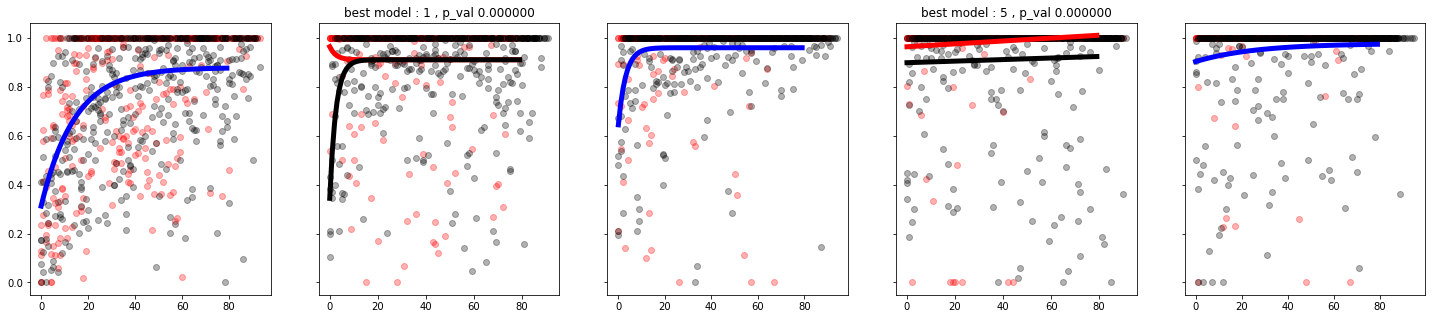

In [17]:
# lick_acc_results_familiar = run_model_comparisons_familiar(KO_sessions,CTRL_sessions, 'lick_acc')
fig, ax = plot_acc_fam(lick_acc_results_familiar, 'lick_acc')

In [12]:
# repeat above for novel arm 

def run_model_comparisons_novel(KO_sessions,CTRL_sessions,metric):
    
    
    ko_mice = [k for k in KO_sessions.keys()]
    ctrl_mice = [k for k in CTRL_sessions.keys()]
    
    perms = generate_perms(ko_mice,ctrl_mice)
    all_sessions = {**KO_sessions, **CTRL_sessions}
    
    results = []
    fig,ax = plt.subplots()
    for day in range(5):
        
        X = []
        acc = []
        for mouse, d_list in KO_sessions.items():
            d = d_list[day]
            
            novel = d['LR'][0]
            fam = novel*-1
            print(mouse,novel)
            _acc = d[metric][(d['block_number']==5)*(d['probes']==0)*(d['omissions']==0)*(d['LR']==novel)]
            
            trials = np.arange(_acc.shape[0])
            if mouse=='4467975.4' and day==0:
                mask = np.ones(_acc.shape)>0
                mask[24-5:68-5] = False
                _acc = _acc[mask]
                trials = trials[mask]
            
            acc.append(_acc)
            _x = np.zeros([2,trials.shape[0]])
            _x[0,:] = trials
            
            X.append(_x)
            
        for mouse, d_list in CTRL_sessions.items():
            d = d_list[day]
            novel = d['LR'][0]
            fam = novel*-1
            _acc = d[metric][(d['block_number']==5)*(d['probes']==0)*(d['omissions']==0)*(d['LR']==novel)]
            acc.append(_acc)
            trials = np.arange(_acc.shape[0])
            _x = np.ones([2,trials.shape[0]])
            _x[0,:] = trials
            
            X.append(_x)
    
        acc = np.concatenate(acc, axis=-1)
#         print(acc.shape)
        X = np.concatenate(X,axis=-1)
        
        random_order = np.random.permutation(int(acc.shape[0]))
        X = X[:,random_order]
        acc = acc[random_order]
#         print(random_order)
        
        
        print(acc.shape,X.shape)
        
        bic_vec, SSE, dof, popt_list, SSE_cv = fit_models(X, acc, crossval=True)
        print(SSE_cv)
       
                   
        
        ax.plot(bic_vec,color=plt.cm.magma(day/4.))
        print('min bic', np.argmin(bic_vec), 'min bic val', np.amin(bic_vec)-bic_vec[0])
        
        perm_SSE = []
        for p, (l0,l1) in enumerate(perms):
            
            X = []
            acc = []
            
            for mouse, d_list in {mouse:all_sessions[mouse] for mouse in l0}.items():
                d = d_list[day]
                novel = d['LR'][0]
                fam = novel*-1
                _acc = d[metric][(d['block_number']==5)*(d['probes']==0)*(d['omissions']==0)*(d['LR']==novel)]
                trials = np.arange(_acc.shape[0])
                
                
                if mouse=='4467975.4' and day==0:
                    mask = np.ones(_acc.shape)>0
                    mask[24-5:68-5] = False
                    _acc = _acc[mask]
                    trials = trials[mask]
                
                acc.append(_acc)
                
                _x = np.zeros([2,trials.shape[0]])
                _x[0,:] = trials

                X.append(_x)

            for mouse, d_list in {mouse:all_sessions[mouse] for mouse in l1}.items():
                d = d_list[day]
                novel = d['LR'][0]
                fam = novel*-1
                _acc = d[metric][(d['block_number']==5)*(d['probes']==0)*(d['omissions']==0)*(d['LR']==novel)]
                trials = np.arange(_acc.shape[0])
                if mouse=='4467975.4' and day==0:
                    mask = np.ones(_acc.shape)>0
                    mask[24-5:68-5] = False
                    _acc = _acc[mask]
                    trials = trials[mask]

                acc.append(_acc)
                _x = np.ones([2,trials.shape[0]])
                _x[0,:] = trials

                X.append(_x)
            
            acc = np.concatenate(acc, axis=-1)
            X = np.concatenate(X,axis=-1)
            random_order = np.random.permutation(int(acc.shape[0]))
            X = X[:,random_order]
            acc = acc[random_order]
            
            _bic_vec, _SSE, _dof, _popt_list, _SSE_cv = fit_models(X, acc, crossval=True)
            perm_SSE.append(_SSE_cv)
            
        print(np.array(perm_SSE).shape)
        perm_SSE = np.array(perm_SSE)
        pvec = []
        for col in range(perm_SSE.shape[1]):
            print("Day %d" % day)
            true_SSE = SSE_cv[col]
            _perm_SSE = perm_SSE[:,col]
            p_val = np.float((true_SSE+1E-3<_perm_SSE).sum())/_perm_SSE.shape[0]
            print("M%d, true SSE %f, lowest perm SSE %f, 'p' value %f" % (col, true_SSE, np.amax(_perm_SSE),p_val))
            pvec.append(p_val)
            
            
        results.append({'bic_vec': bic_vec, 'popt_list': popt_list, 'LL_cv': SSE_cv, 'p_val':pvec})
        
    return results
    
def plot_acc_nov(results, metric):
    fig,ax = plt.subplots(1,5,figsize=[25,5], sharey=True)
    for day in range(5):
        
        for mouse, d_list in KO_sessions.items():
            d = d_list[day]
            novel = d['LR'][0]
            acc = d[metric][(d['block_number']==5)*(d['probes']==0)*(d['LR']==novel)]
            trials = np.arange(acc.shape[0])
            
            ax[day].scatter(trials,acc,alpha=.3, color='red')
            
        for mouse, d_list in CTRL_sessions.items():
            d = d_list[day]
            novel = d['LR'][0]
            acc = d[metric][(d['block_number']==5)*(d['probes']==0)*(d['LR']==novel)]
            trials = np.arange(acc.shape[0])
            
            ax[day].scatter(trials,acc,alpha=.3, color='black')
            
            
        LL_cv = results[day]['LL_cv']
        pval = np.array(results[day]['p_val'])
#         ax[day].plot(LL_cv)
        if True:
            # first stage 
            # M0 baseline model
            # M1 groupwise intercept
            # M2 groupwise slope
            # M3 groupwise slope and intercept
            # M4 groupwise asymptote
            # M5 groupwise intercept and asymptote
            # M6 groupwise slope and asymptote
            # M7 groupwise intercept, slope, and asymptote

            onep_inds = [1,2,4]
            onep_LLR = LL_cv[onep_inds] - LL_cv[0]
            onep_pval = pval[onep_inds]

            best_onep_ind = np.argmax(onep_LLR)
            if (onep_pval[best_onep_ind]<.01) and onep_LLR[best_onep_ind]>5:

                if best_onep_ind == 0:
                    twop_inds = [3,5]
                    twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[0]]
                    twop_pval = pval[twop_inds]


                elif best_onep_ind == 1:
                    twop_inds = [3,6]
                    twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[1]]
                    twop_pval = pval[twop_inds]
                elif best_onep_ind == 2:
                    twop_inds = [5,6]
                    twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[2]]
                    twop_pval = pval[twop_inds]
                else:
                    print("onep fail")

                best_twop_ind = np.argmax(twop_LLR)
                if (twop_LLR[best_twop_ind]>5) and (twop_pval[best_twop_ind]<.01):
                    
                    threep_LLR = LL_cv[-1] - LL_cv[twop_inds[best_twop_ind]]
                    if (threep_LLR>5) and (pval[-1]<.05):
                        bestmodel = 7
                    else:
                        bestmodel = twop_inds[best_twop_ind]
                    
                else:
                    bestmodel = onep_inds[best_onep_ind]

            else:
                bestmodel = 0

            X = np.zeros([2,20])
            X[0,:] = np.arange(20)
            m_list = [M0, M1, M2, M3, M4, M5, M6, M7]
            M = m_list[bestmodel]


            if not bestmodel==0:

                ax[day].plot(X[0,:],M(X,*results[day]['popt_list'][bestmodel]),color='red',linewidth=5)

                X[1,:] = 1
                ax[day].plot(X[0,:],M(X,*results[day]['popt_list'][bestmodel]),color='black',linewidth=5)

                ax[day].set_title("best model : %d , p_val %f" % (bestmodel, results[day]['p_val'][bestmodel]))
            else:
                ax[day].plot(X[0,:],M(X,*results[day]['popt_list'][bestmodel]),color='blue',linewidth=5)


    return fig, ax





4467975.1 1.0
4467975.2 -1.0
4467975.3 1.0
4467975.4 -1.0
4467975.5 1.0
(168,) (2, 168)
[-1658.52716603 -1650.74659565 -1645.90093196 -1645.41896493
 -1649.22426696 -1649.45000432 -1645.72170504 -1645.45442408]
min bic 0 min bic val 0.0
(250, 8)
Day 0
M0, true SSE -1658.527166, lowest perm SSE -1657.588238, 'p' value 0.496000
Day 0
M1, true SSE -1650.746596, lowest perm SSE -1572.615526, 'p' value 0.504000
Day 0
M2, true SSE -1645.900932, lowest perm SSE -1571.470881, 'p' value 0.480000
Day 0
M3, true SSE -1645.418965, lowest perm SSE -1568.695048, 'p' value 0.516000
Day 0
M4, true SSE -1649.224267, lowest perm SSE -1564.659611, 'p' value 0.464000
Day 0
M5, true SSE -1649.450004, lowest perm SSE -1564.946899, 'p' value 0.544000
Day 0
M6, true SSE -1645.721705, lowest perm SSE -1566.010771, 'p' value 0.572000
Day 0
M7, true SSE -1645.454424, lowest perm SSE -1564.341607, 'p' value 0.604000
4467975.1 1.0
4467975.2 -1.0
4467975.3 1.0
4467975.4 -1.0
4467975.5 1.0
(166,) (2, 166)
[-1435.590

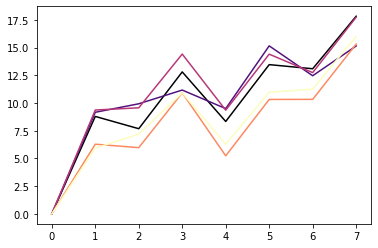

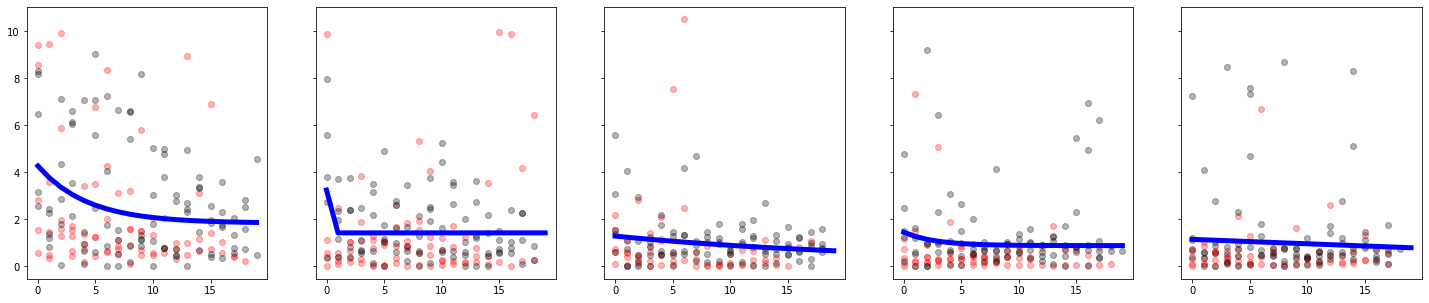

In [13]:
lick_varpos_results_novel = run_model_comparisons_novel(KO_sessions,CTRL_sessions, 'lick_varpos')
fig, ax = plot_acc_nov(lick_varpos_results_novel, 'lick_varpos')

(766,) (2, 766)
[-40.40042669 -40.64855112 -39.42945762 -41.6751392  -40.04447888
 -40.3079288  -42.41178644 -38.56333572]
min bic 0 min bic val 0.0


<ipython-input-6-78599f037e8c>:42: RuntimeWarning: overflow encountered in exp
  return  (a0*X[1,:] +a1*(1-X[1,:]))*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])
<ipython-input-6-78599f037e8c>:42: RuntimeWarning: overflow encountered in multiply
  return  (a0*X[1,:] +a1*(1-X[1,:]))*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])


(250, 8)
Day 0
M0, true SSE -40.400427, lowest perm SSE -39.982062, 'p' value 0.440000
Day 0
M1, true SSE -40.648551, lowest perm SSE 1306.772111, 'p' value 0.920000
Day 0
M2, true SSE -39.429458, lowest perm SSE 1220.507908, 'p' value 0.896000
Day 0
M3, true SSE -41.675139, lowest perm SSE 1309.658872, 'p' value 0.976000
Day 0
M4, true SSE -40.044479, lowest perm SSE 1335.308753, 'p' value 0.956000
Day 0
M5, true SSE -40.307929, lowest perm SSE 1365.520805, 'p' value 0.972000
Day 0
M6, true SSE -42.411786, lowest perm SSE 1333.874318, 'p' value 0.968000
Day 0
M7, true SSE -38.563336, lowest perm SSE 1366.143811, 'p' value 0.936000
(774,) (2, 774)
[559.1238934  594.6926251  601.8286181  601.64230975 594.38243036
 602.66732677 601.6223431  603.36501611]
min bic 0 min bic val 0.0


<ipython-input-6-78599f037e8c>:37: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c0*X[1,:] + c1*(1-X[1,:])


(250, 8)
Day 1
M0, true SSE 559.123893, lowest perm SSE 560.202290, 'p' value 0.820000
Day 1
M1, true SSE 594.692625, lowest perm SSE 1294.966870, 'p' value 0.700000
Day 1
M2, true SSE 601.828618, lowest perm SSE 1220.165014, 'p' value 0.636000
Day 1
M3, true SSE 601.642310, lowest perm SSE 1313.156882, 'p' value 0.696000
Day 1
M4, true SSE 594.382430, lowest perm SSE 1295.224682, 'p' value 0.688000
Day 1
M5, true SSE 602.667327, lowest perm SSE 1313.156599, 'p' value 0.688000
Day 1
M6, true SSE 601.622343, lowest perm SSE 1313.157585, 'p' value 0.688000
Day 1
M7, true SSE 603.365016, lowest perm SSE 1314.455365, 'p' value 0.680000
(779,) (2, 779)
[1291.28946895 1359.93016611 1382.64596248 1377.82771298 1365.70440802
 1382.07309794 1380.8088488  1382.92874834]
min bic 2 min bic val -4.983260978859789


<ipython-input-6-78599f037e8c>:22: RuntimeWarning: overflow encountered in exp
  return (a0*X[1,:] +a1*(1-X[1,:]) )*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c


(250, 8)
Day 2
M0, true SSE 1291.289469, lowest perm SSE 1291.957520, 'p' value 0.856000
Day 2
M1, true SSE 1359.930166, lowest perm SSE 2560.610691, 'p' value 0.528000
Day 2
M2, true SSE 1382.645962, lowest perm SSE 2414.480479, 'p' value 0.464000
Day 2
M3, true SSE 1377.827713, lowest perm SSE 2580.619655, 'p' value 0.528000
Day 2
M4, true SSE 1365.704408, lowest perm SSE 2552.529300, 'p' value 0.520000
Day 2
M5, true SSE 1382.073098, lowest perm SSE 2560.954096, 'p' value 0.528000
Day 2
M6, true SSE 1380.808849, lowest perm SSE 2554.996922, 'p' value 0.520000
Day 2
M7, true SSE 1382.928748, lowest perm SSE 2574.439338, 'p' value 0.528000
(775,) (2, 775)
[1487.38449187 1498.62801895 1522.42670541 1527.41806616 1510.47086095
 1535.11311662 1532.86154385 1536.84943977]
min bic 0 min bic val 0.0


<ipython-input-6-78599f037e8c>:22: RuntimeWarning: overflow encountered in exp
  return (a0*X[1,:] +a1*(1-X[1,:]) )*np.exp(-1*(b0*X[1,:] + b1*(1-X[1,:]))*X[0,:]) + c


(250, 8)
Day 3
M0, true SSE 1487.384492, lowest perm SSE 1487.887972, 'p' value 0.404000
Day 3
M1, true SSE 1498.628019, lowest perm SSE 2404.445726, 'p' value 0.808000
Day 3
M2, true SSE 1522.426705, lowest perm SSE 2327.202059, 'p' value 0.716000
Day 3
M3, true SSE 1527.418066, lowest perm SSE 2450.677924, 'p' value 0.700000
Day 3
M4, true SSE 1510.470861, lowest perm SSE 2371.445833, 'p' value 0.700000
Day 3
M5, true SSE 1535.113117, lowest perm SSE 2422.325467, 'p' value 0.688000
Day 3
M6, true SSE 1532.861544, lowest perm SSE 2466.092900, 'p' value 0.724000
Day 3
M7, true SSE 1536.849440, lowest perm SSE 2467.225955, 'p' value 0.712000
(780,) (2, 780)
[344.56014827 507.67182477 509.39339069 516.88693662 507.75883806
 516.04020607 516.8098816  517.22205216]
min bic 2 min bic val -19.760990406608173
(250, 8)
Day 4
M0, true SSE 344.560148, lowest perm SSE 344.999264, 'p' value 0.724000
Day 4
M1, true SSE 507.671825, lowest perm SSE 1514.313081, 'p' value 0.344000
Day 4
M2, true SSE 5

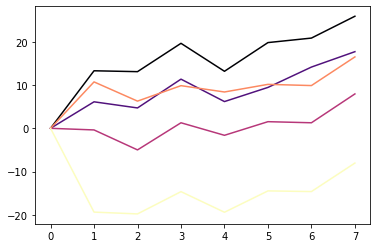

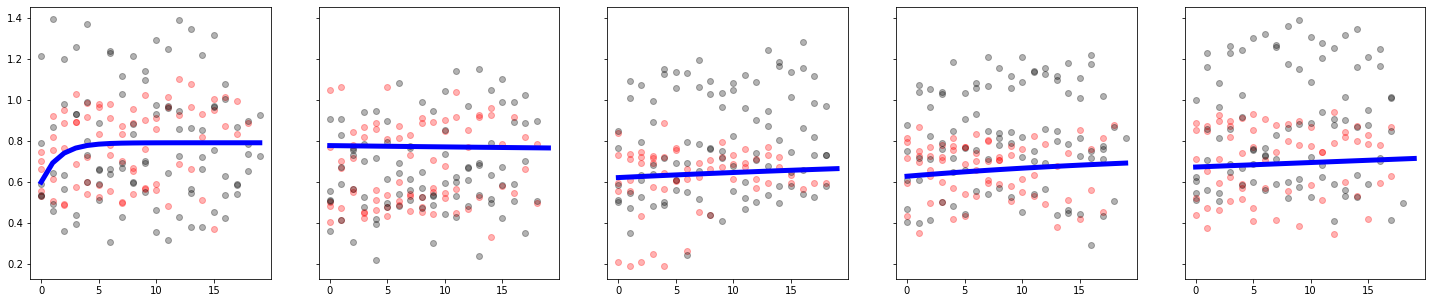

In [14]:
lick_armspeed_norm_results_novel = run_model_comparisons_familiar(KO_sessions,CTRL_sessions, 'arm_speed_norm')
fig, ax = plot_acc_nov(lick_armspeed_norm_results_novel, 'arm_speed_norm')

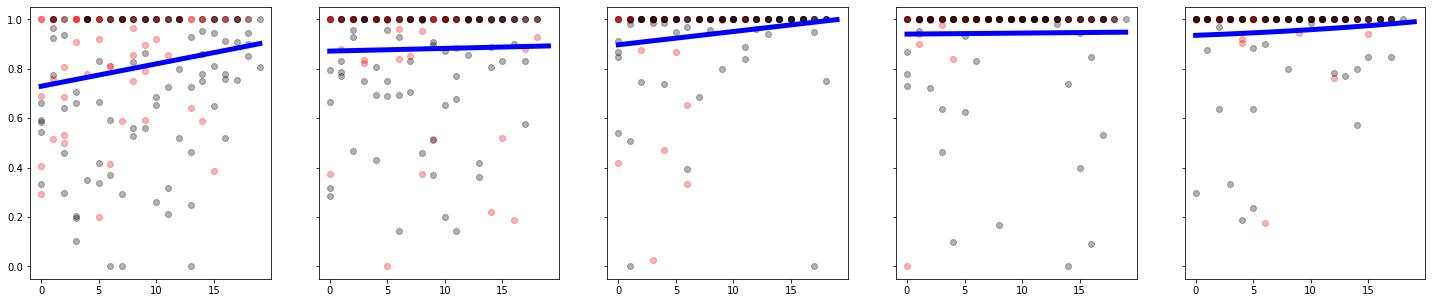

In [16]:
# lick_acc_results_novel = run_model_comparisons_novel(KO_sessions,CTRL_sessions, 'lick_acc')
fig, ax = plot_acc_nov(lick_acc_results_novel, 'lick_acc')

In [ ]:
# plot number of omissions

# plot average lickrate for each mouse for different trial types

# plot probe trial lickrate

In [32]:
def concat_lickrate(d_list):
    lr_rz_early_norm = []
    lr_rz_late_norm = []
    for j,d in enumerate(d_list):
        if j == 0:
            baseline_early_inds = (d['block_number']<2)*(d['LR']==-1)
            baseline_late_inds = (d['block_number']<2)*(d['LR']==1)
            baseline_early = d['lickrate_rz_early'][baseline_early_inds].mean()
            baseline_late = d['lickrate_rz_late'][baseline_late_inds].mean()


            nonbaseline_inds = d['block_number']>=2
            lr_rz_early_norm.append(d['lickrate_rz_early'][nonbaseline_inds*(d['LR']==-1)]/baseline_early)
            lr_rz_late_norm.append(d['lickrate_rz_late'][nonbaseline_inds*(d['LR']==1)]/baseline_late)

        elif j ==1 :    
            nonbaseline_inds = d['LR']==-1
            lr_rz_early_norm.append(d['lickrate_rz_early'][d['LR']==-1]/baseline_early)
            lr_rz_late_norm.append(d['lickrate_rz_late'][d['LR']==1]/baseline_late)
        else:
            nonbaseline_inds = d['block_number']<2
            lr_rz_early_norm.append(d['lickrate_rz_early'][nonbaseline_inds*(d['LR']==-1)]/baseline_early)
            lr_rz_late_norm.append(d['lickrate_rz_late'][nonbaseline_inds*(d['LR']==1)]/baseline_late)

    lr_rz_early_norm = np.concatenate(lr_rz_early_norm)
    lr_rz_late_norm = np.concatenate(lr_rz_late_norm)

    inds_early = np.arange(lr_rz_early_norm.shape[0])
    inds_late = np.arange(lr_rz_late_norm.shape[0])
        
        
    return {'early_rz_inds': inds_early, 'early_rz_lr': lr_rz_early_norm, 'late_rz_inds':inds_late, 'late_rz_lr': lr_rz_late_norm}






def _run_rev_model_fit(all_reversal_lrs, l0, l1, metric): 
    
    y = []
    x = []
    for mouse, _y in {mouse:all_reversal_lrs[mouse][metric] for mouse in l0}.items(): 
        trials = np.arange(_y.shape[0])
        y.append(_y)
        _x = np.zeros([2,trials.shape[0]])
        _x[0,:] = trials

        x.append(_x)
        
    for mouse, _y in {mouse:all_reversal_lrs[mouse][metric] for mouse in l1}.items(): 
        trials = np.arange(_y.shape[0])
        y.append(_y)
        _x = np.ones([2,trials.shape[0]])
        _x[0,:] = trials

        x.append(_x)

    y = np.concatenate(y, axis=-1)
    x = np.concatenate(x,axis=-1)
    random_order = np.random.permutation(int(y.shape[0]))
    x = x[:,random_order]
    y = y[random_order]
            
    bic_vec, sse, dof, popt_list, ll_cv = fit_models(x, y, crossval=True)
    
    return bic_vec, sse, dof, popt_list, ll_cv



def run_model_comparisions_rev_lr(KO_sessions,CTRL_sessions, metric):
    ko_mice = [k for k in KO_sessions.keys()]
    ctrl_mice = [k for k in CTRL_sessions.keys()]

    
    KO_reversal_lrs={mouse:concat_lickrate(d_list[-3:]) for mouse,d_list in KO_sessions.items()}
    CTRL_reversal_lrs={mouse:concat_lickrate(d_list[-3:]) for mouse,d_list in CTRL_sessions.items()}
    all_reversal_lrs = {**KO_reversal_lrs, **CTRL_reversal_lrs}
    bic_vec, sse, dof, popt_list, ll_cv = _run_rev_model_fit(all_reversal_lrs, ko_mice, ctrl_mice, metric)
    print('log-likelihood', ll_cv)
    perms = generate_perms(ko_mice,ctrl_mice)
    perm_ll = []
    print('running permutations')
    for i, (l0,l1) in enumerate(perms):
        if i%50==0:
            print('perm ', i)
        _bic_vec, _ll, _dof, _popt_list, _ll_cv = _run_rev_model_fit(all_reversal_lrs, l0, l1, metric)
    
        perm_ll.append(_ll_cv)
            
    print(np.array(perm_ll).shape)
    perm_ll = np.array(perm_ll)
    pvec = []
    for col in range(perm_ll.shape[1]):
        
        true_ll = ll_cv[col]
        _perm_ll = perm_ll[:,col]
        p_val = np.float((true_ll+1E-3<_perm_ll).sum())/_perm_ll.shape[0]
        print("M%d, true SSE %f, lowest perm SSE %f, 'p' value %f" % (col, true_ll, np.amax(_perm_ll),p_val))
        pvec.append(p_val)
            
            
    return {'bic_vec': bic_vec, 'popt_list': popt_list, 'LL_cv': ll_cv, 'p_val':np.array(pvec)}


def _pick_best_model(LL_cv, pval):
    
    
    # first stage 
    # M0 baseline model
    # M1 groupwise intercept
    # M2 groupwise slope
    # M3 groupwise slope and intercept
    # M4 groupwise asymptote
    # M5 groupwise intercept and asymptote
    # M6 groupwise slope and asymptote
    # M7 groupwise intercept, slope, and asymptote

    onep_inds = [1,2,4]
    onep_LLR = LL_cv[onep_inds] - LL_cv[0]
    onep_pval = pval[onep_inds]

    best_onep_ind = np.argmax(onep_LLR)
    if (onep_pval[best_onep_ind]<.01) and onep_LLR[best_onep_ind]>5:

        if best_onep_ind == 0:
            twop_inds = [3,5]
            twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[0]]
            twop_pval = pval[twop_inds]


        elif best_onep_ind == 1:
            twop_inds = [3,6]
            twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[1]]
            twop_pval = pval[twop_inds]
        elif best_onep_ind == 2:
            twop_inds = [5,6]
            twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[2]]
            twop_pval = pval[twop_inds]
        else:
            print("onep fail")

        best_twop_ind = np.argmax(twop_LLR)
        if (twop_LLR[best_twop_ind]>5) and (twop_pval[best_twop_ind]<.01):

            threep_LLR = LL_cv[-1] - LL_cv[twop_inds[best_twop_ind]]
            if (threep_LLR>5) and (pval[-1]<.01):
                bestmodel = 7
            else:
                bestmodel = twop_inds[best_twop_ind]

        else:
            bestmodel = onep_inds[best_onep_ind]

    else:
        bestmodel = 0
        
    return bestmodel
    

def plot_reversal_lrs(results, curr_ax):
   
    LL_cv = results['LL_cv']
    pval = np.array(results['p_val'])
    
    

    X = np.zeros([2,120])
    X[0,:] = np.arange(120)
    
    
    bestmodel = _pick_best_model(LL_cv,pval)
    
    m_list = [M0, M1, M2, M3, M4, M5, M6, M7]
    M = m_list[bestmodel]

    if not bestmodel==0:

        curr_ax.plot(X[0,:],M(X,*results['popt_list'][bestmodel]),color='red',linewidth=5)

        X[1,:] = 1
        curr_ax.plot(X[0,:],M(X,*results['popt_list'][bestmodel]),color='black',linewidth=5)

        curr_ax.set_title("best model : %d , p_val %f" % (bestmodel, results['p_val'][bestmodel]))
    else:
        curr_ax.plot(X[0,:],M(X,*results['popt_list'][bestmodel]),color='blue',linewidth=5)






# fig,ax = run_reversal_lrs(KO_sessions,CTRL_sessions)
# fig.savefig(os.path.join(figdir_local,"LickingExtinction.pdf"),format = 'pdf')
# fig.savefig(os.path.join(figdir_local,"LickingExctinction.png"),format = 'png')
    
    
    

# def plot_acc_nov(results, metric):
#     fig,ax = plt.subplots(1,5,figsize=[25,5], sharey=True)
#     for day in range(5):
        
#         for mouse, d_list in KO_sessions.items():
#             d = d_list[day]
#             novel = d['LR'][0]
#             acc = d[metric][(d['block_number']==5)*(d['probes']==0)*(d['LR']==novel)]
#             trials = np.arange(acc.shape[0])
            
#             ax[day].scatter(trials,acc,alpha=.3, color='red')
            
#         for mouse, d_list in CTRL_sessions.items():
#             d = d_list[day]
#             novel = d['LR'][0]
#             acc = d[metric][(d['block_number']==5)*(d['probes']==0)*(d['LR']==novel)]
#             trials = np.arange(acc.shape[0])
            
#             ax[day].scatter(trials,acc,alpha=.3, color='black')
            
            
#         LL_cv = results[day]['LL_cv']
#         pval = np.array(results[day]['p_val'])
# #         ax[day].plot(LL_cv)
#         if True:
#             # first stage 
#             # M0 baseline model
#             # M1 groupwise intercept
#             # M2 groupwise slope
#             # M3 groupwise slope and intercept
#             # M4 groupwise asymptote
#             # M5 groupwise intercept and asymptote
#             # M6 groupwise slope and asymptote
#             # M7 groupwise intercept, slope, and asymptote

#             onep_inds = [1,2,4]
#             onep_LLR = LL_cv[onep_inds] - LL_cv[0]
#             onep_pval = pval[onep_inds]

#             best_onep_ind = np.argmax(onep_LLR)
#             if (onep_pval[best_onep_ind]<.01) and onep_LLR[best_onep_ind]>5:

#                 if best_onep_ind == 0:
#                     twop_inds = [3,5]
#                     twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[0]]
#                     twop_pval = pval[twop_inds]


#                 elif best_onep_ind == 1:
#                     twop_inds = [3,6]
#                     twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[1]]
#                     twop_pval = pval[twop_inds]
#                 elif best_onep_ind == 2:
#                     twop_inds = [5,6]
#                     twop_LLR = LL_cv[twop_inds] - LL_cv[onep_inds[2]]
#                     twop_pval = pval[twop_inds]
#                 else:
#                     print("onep fail")

#                 best_twop_ind = np.argmax(twop_LLR)
#                 if (twop_LLR[best_twop_ind]>5) and (twop_pval[best_twop_ind]<.01):
                    
#                     threep_LLR = LL_cv[-1] - LL_cv[twop_inds[best_twop_ind]]
#                     if (threep_LLR>5) and (pval[-1]<.05):
#                         bestmodel = 7
#                     else:
#                         bestmodel = twop_inds[best_twop_ind]
                    
#                 else:
#                     bestmodel = onep_inds[best_onep_ind]

#             else:
#                 bestmodel = 0

#             X = np.zeros([2,20])
#             X[0,:] = np.arange(20)
#             m_list = [M0, M1, M2, M3, M4, M5, M6, M7]
#             M = m_list[bestmodel]


#             if not bestmodel==0:

#                 ax[day].plot(X[0,:],M(X,*results[day]['popt_list'][bestmodel]),color='red',linewidth=5)

#                 X[1,:] = 1
#                 ax[day].plot(X[0,:],M(X,*results[day]['popt_list'][bestmodel]),color='black',linewidth=5)

#                 ax[day].set_title("best model : %d , p_val %f" % (bestmodel, results[day]['p_val'][bestmodel]))
#             else:
#                 ax[day].plot(X[0,:],M(X,*results[day]['popt_list'][bestmodel]),color='blue',linewidth=5)


#     return fig, ax


In [25]:
results_early_rz_rev = run_model_comparisions_rev_lr(KO_sessions,CTRL_sessions, 'early_rz_lr')
results_late_rz_rev = run_model_comparisions_rev_lr(KO_sessions,CTRL_sessions, 'late_rz_lr')



log-likelihood [-3264.81594912 -3165.10248575 -3058.79620899 -3046.77404569
 -3111.75788618 -3066.44193122 -3045.45465767 -3045.2010427 ]
running permutations
perm  0
perm  50
perm  100
perm  150
perm  200
(250, 8)
M0, true SSE -3264.815949, lowest perm SSE -3264.680821, 'p' value 0.072000
M1, true SSE -3165.102486, lowest perm SSE -3134.733630, 'p' value 0.032000
M2, true SSE -3058.796209, lowest perm SSE -3057.166498, 'p' value 0.008000
M3, true SSE -3046.774046, lowest perm SSE -3043.232384, 'p' value 0.008000
M4, true SSE -3111.757886, lowest perm SSE -3093.238046, 'p' value 0.016000
M5, true SSE -3066.441931, lowest perm SSE -3060.463880, 'p' value 0.008000
M6, true SSE -3045.454658, lowest perm SSE -3042.335968, 'p' value 0.008000
M7, true SSE -3045.201043, lowest perm SSE -3042.283259, 'p' value 0.008000
log-likelihood [-2330.86490171 -2330.62719929 -2330.20784038 -2330.47623102
 -2329.18663972 -2329.16943228 -2328.58619553 -2328.34617184]
running permutations
perm  0
perm  50
p

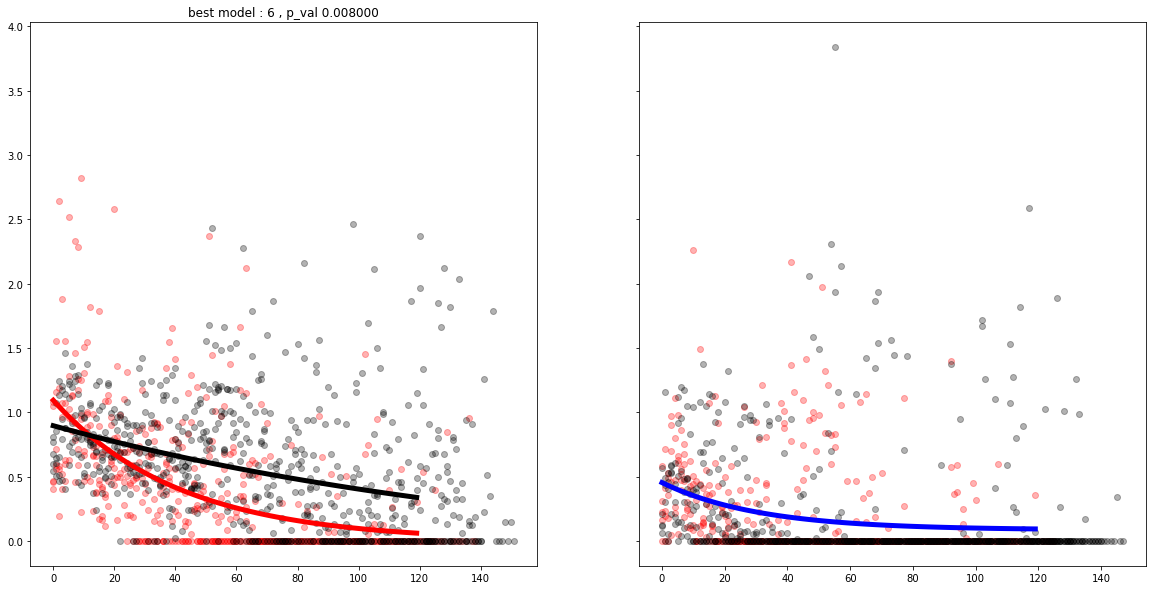

In [35]:
fig,ax = plt.subplots(1,2,figsize=[20,10], sharey=True)
ax[0].scatter(ko_concat_lrs['early_rz_inds'],ko_concat_lrs['early_rz_lr'],color='red',alpha=.3)
ax[0].scatter(ctrl_concat_lrs['early_rz_inds'],ctrl_concat_lrs['early_rz_lr'],color='black',alpha=.3)
plot_reversal_lrs(results_early_rz_rev, ax[0])

ax[1].scatter(ko_concat_lrs['late_rz_inds'],ko_concat_lrs['late_rz_lr'],color='red',alpha=.3)
ax[1].scatter(ctrl_concat_lrs['late_rz_inds'],ctrl_concat_lrs['late_rz_lr'],color='black',alpha=.3)
plot_reversal_lrs(results_late_rz_rev, ax[1])

[-0.02607434  0.01673519  0.1272216 ]
dict_keys(['4467975.1', '4467975.2', '4467975.3', '4467975.4', '4467975.5', '4467331.1', '4467331.2', '4467332.1', '4467332.2', '4467333.1'])
[-0.02607434  0.01673519  0.1272216 ] [-0.00592626  0.00889762 -0.0213185 ]
(250, 3) (250, 3)
Left values [ 1.55733837  0.02571456 -0.98603693] [ 1.57000741  0.05823739 -0.63663489]
p-values [0.532, 0.09599999999999997, 0.31599999999999995]
Right values [ 1.56408115  0.06713501 -0.65795339] [ 1.57000741  0.05823739 -0.63663489]
p-values [0.508, 0.404, 0.54]


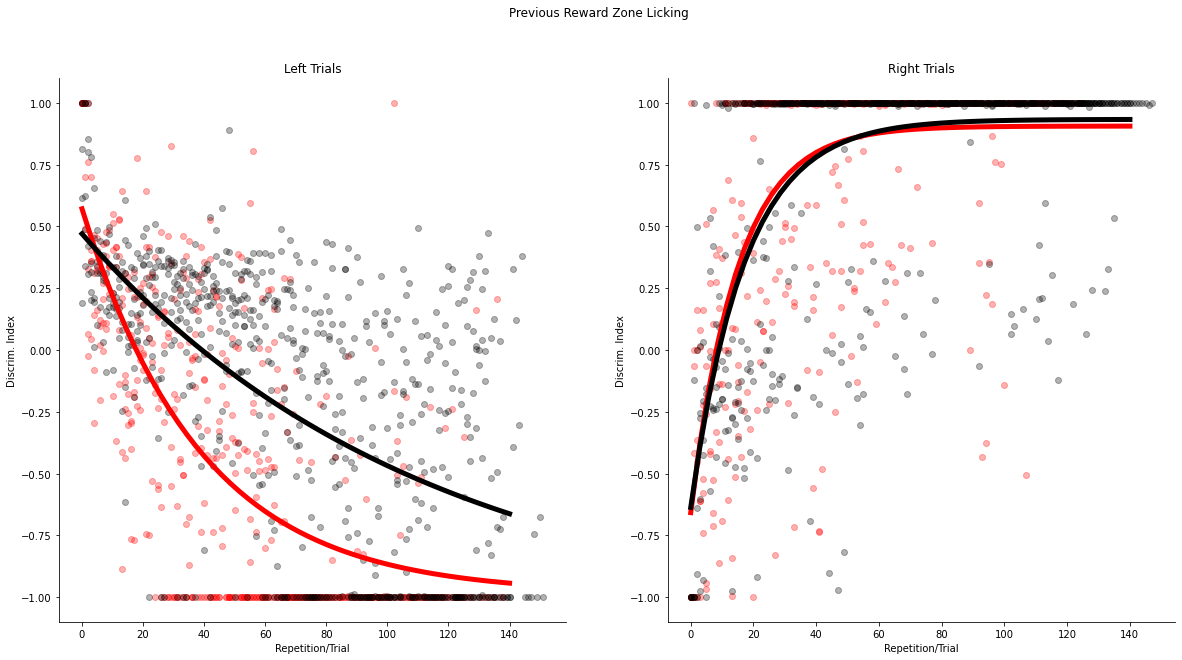

In [73]:
def concat_discrim(d_list):
    lr_discrim_left = []
    lr_discrim_right = []
    for j,d in enumerate(d_list[-3:]):
        if j == 0:    
            nonbaseline_inds = d['block_number']>=2
            lr_discrim_left.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_discrim_right.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
        elif j ==1 :
            lr_discrim_left.append(d['lickrate_dprime'][(d['LR']==-1)])
            lr_discrim_right.append(d['lickrate_dprime'][(d['LR']==1)])
        else:
            nonbaseline_inds = (d['block_number']<2)
            lr_discrim_left.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_discrim_right.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
            
    lr_discrim_left = np.concatenate(lr_discrim_left)
    lr_discrim_right = np.concatenate(lr_discrim_right)

    inds_left = np.arange(lr_discrim_left.shape[0])
    inds_right = np.arange(lr_discrim_right.shape[0])
        
        
    return {'left_inds': inds_left, 'left_discrim': lr_discrim_left, 'right_inds':inds_right, 'right_discrim': lr_discrim_right}




def run_reversal_discrim(KO_sessions,CTRL_sessions):
    
    ko_mice = [k for k in KO_sessions.keys()]
    ctrl_mice = [k for k in CTRL_sessions.keys()]

    KO_reversal_lrs={mouse:concat_discrim(d_list[-3:]) for mouse,d_list in KO_sessions.items()}
    KO_concat_lrs = _concat_dicts(KO_reversal_lrs,['left_inds', 'left_discrim', 'right_inds', 'right_discrim'])
    
    CTRL_reversal_lrs={mouse:concat_discrim(d_list[-3:]) for mouse,d_list in CTRL_sessions.items()}
    CTRL_concat_lrs = _concat_dicts(CTRL_reversal_lrs,['left_inds', 'left_discrim', 'right_inds', 'right_discrim'])
    
    all_reversal_lrs = {**KO_reversal_lrs, **CTRL_reversal_lrs}
    
    KO_left_popt, KO_left_pcov = curve_fit(monoexp_decay_wint, KO_concat_lrs['left_inds'], KO_concat_lrs['left_discrim'])
    CTRL_left_popt, CTRL_left_pcov = curve_fit(monoexp_decay_wint, CTRL_concat_lrs['left_inds'], CTRL_concat_lrs['left_discrim'])
    
    left_true_diff = KO_left_popt-CTRL_left_popt
    print(left_true_diff)
    
    KO_right_popt, KO_right_pcov = curve_fit(monoexp_growth_wint, KO_concat_lrs['right_inds'], KO_concat_lrs['right_discrim'], maxfev=int(1E5))
    CTRL_right_popt, CTRL_right_pcov = curve_fit(monoexp_growth_wint, CTRL_concat_lrs['right_inds'], CTRL_concat_lrs['right_discrim'], maxfev=int(1E5))
    
    right_true_diff = KO_right_popt - CTRL_right_popt
    
    fig,ax = plt.subplots(1,2,figsize=[20,10])
    ax[0].scatter(KO_concat_lrs['left_inds'],KO_concat_lrs['left_discrim'],color='red',alpha=.3)
    ax[0].scatter(CTRL_concat_lrs['left_inds'],CTRL_concat_lrs['left_discrim'],color='black',alpha=.3)

    ax[1].scatter(KO_concat_lrs['right_inds'],KO_concat_lrs['right_discrim'],color='red',alpha=.3)
    ax[1].scatter(CTRL_concat_lrs['right_inds'],CTRL_concat_lrs['right_discrim'],color='black',alpha=.3)
    
    perms = generate_perms(ko_mice,ctrl_mice)
    
    left_perm_diff, right_perm_diff = [], []
    print(all_reversal_lrs.keys())
    for (l0,l1) in perms:
        l0_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l0},['left_inds', 'left_discrim', 'right_inds', 'right_discrim'])
        l1_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l1},['left_inds', 'left_discrim', 'right_inds', 'right_discrim'])
        
    
    
        l0_left_popt, l0_left_pcov = curve_fit(monoexp_decay_wint, l0_concat_lrs['left_inds'], l0_concat_lrs['left_discrim'], maxfev=int(1E5))
        l1_left_popt, l1_left_pcov = curve_fit(monoexp_decay_wint, l1_concat_lrs['left_inds'], l1_concat_lrs['left_discrim'], maxfev=int(1E5))
    
        left_perm_diff.append(l0_left_popt-l1_left_popt)
    
        l0_right_popt, l0_right_pcov = curve_fit(monoexp_growth_wint, l0_concat_lrs['right_inds'], l0_concat_lrs['right_discrim'], maxfev=int(1E5))
        l1_right_popt, l1_right_pcov = curve_fit(monoexp_growth_wint, l1_concat_lrs['right_inds'], l1_concat_lrs['right_discrim'], maxfev=int(1E5))
    
        right_perm_diff.append(l0_right_popt - l1_right_popt)
        
    left_perm_diff = np.array(left_perm_diff)
    right_perm_diff = np.array(right_perm_diff)
    
    print(left_true_diff, right_true_diff)
    print(left_perm_diff.shape, right_perm_diff.shape)
    print('Left values', KO_left_popt, CTRL_right_popt)
    print('p-values', [1-np.float((left_true_diff[i]>=left_perm_diff[:,i]).sum())/left_perm_diff.shape[0] for i in range(3)])
    
    print('Right values', KO_right_popt, CTRL_right_popt)
    print('p-values', [1-np.float((right_true_diff[i]>=right_perm_diff[:,i]).sum())/right_perm_diff.shape[0] for i in range(3)])
    
    
    t = np.linspace(0,140)
    
    ax[0].plot(t, monoexp_decay_wint(t, *KO_left_popt), color='red',linewidth=5)
    ax[0].plot(t, monoexp_decay_wint(t, *CTRL_left_popt), color='black',linewidth=5)
    
    
    
    
    ax[1].plot(t, monoexp_growth_wint(t, *KO_right_popt), color='red',linewidth=5)
    ax[1].plot(t, monoexp_growth_wint(t, *CTRL_right_popt), color='black',linewidth=5)
    
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    ax[0].set_ylabel('Discrim. Index')
    ax[0].set_xlabel('Repetition/Trial')
    fig.suptitle('Previous Reward Zone Licking')
    ax[0].set_title('Left Trials')
    
    ax[1].set_xlabel('Repetition/Trial')
    ax[1].set_ylabel('Discrim. Index')
    ax[1].set_title('Right Trials')
    
    



run_reversal_discrim(KO_sessions,CTRL_sessions)
    
    
    

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-84-54ebe55280a2>:138: RuntimeWarning: overflow encountered in exp
  return (a-c)*np.exp(-b*x) + c


[1.41994427e-02 4.00260201e+01 3.89089658e-02]
dict_keys(['4467975.1', '4467975.2', '4467975.3', '4467975.4', '4467975.5', '4467331.1', '4467331.2', '4467332.1', '4467332.2', '4467333.1'])
[1.41994427e-02 4.00260201e+01 3.89089658e-02] [0.06176446 3.31762054 0.03834637]
(250, 3) (250, 3)
Left values [3.83302851e-02 4.12788067e+01 6.58679879e-02] [0.0955467  0.35034927 0.22312586]
p-values [0.5840000000000001, 0.06399999999999995, 0.12]
Right values [0.03378224 3.66796981 0.18477949] [0.0955467  0.35034927 0.22312586]
p-values [0.43200000000000005, 0.48, 0.008000000000000007]


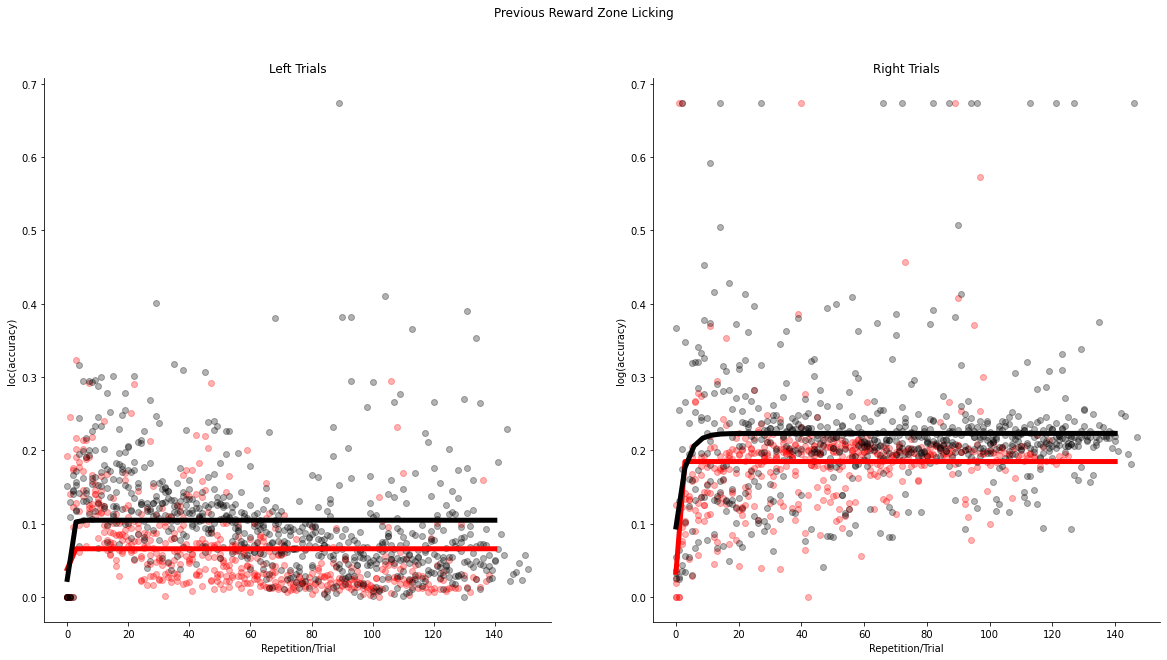

In [90]:
def concat_acc(d_list):
    lr_acc_left = []
    lr_acc_right = []
    for j,d in enumerate(d_list[-3:]):
        if j == 0:    
            nonbaseline_inds = d['block_number']>=2
            lr_acc_left.append(d['lick_err'][nonbaseline_inds*(d['LR']==-1)])
            lr_acc_right.append(d['lick_err'][nonbaseline_inds*(d['LR']==1)])
        elif j ==1 :
            lr_acc_left.append(d['lick_err'][(d['LR']==-1)])
            lr_acc_right.append(d['lick_err'][(d['LR']==1)])
        else:
            nonbaseline_inds = (d['block_number']<2)
            lr_acc_left.append(d['lick_err'][nonbaseline_inds*(d['LR']==-1)])
            lr_acc_right.append(d['lick_err'][nonbaseline_inds*(d['LR']==1)])
            
    lr_acc_left = np.concatenate(lr_acc_left)
    lr_acc_right = np.concatenate(lr_acc_right)

    inds_left = np.arange(lr_acc_left.shape[0])
    inds_right = np.arange(lr_acc_right.shape[0])
        
        
    return {'left_inds': inds_left, 'left_acc': lr_acc_left, 'right_inds':inds_right, 'right_acc': lr_acc_right}

def monoexp_rise(x,a,b):
    return a*(1-np.exp(-b*x)) 


def run_reversal_acc(KO_sessions,CTRL_sessions):
    
    ko_mice = [k for k in KO_sessions.keys()]
    ctrl_mice = [k for k in CTRL_sessions.keys()]

    KO_reversal_lrs={mouse:concat_acc(d_list[-3:]) for mouse,d_list in KO_sessions.items()}
    KO_concat_lrs = _concat_dicts(KO_reversal_lrs,['left_inds', 'left_acc', 'right_inds', 'right_acc'])
    
    CTRL_reversal_lrs={mouse:concat_acc(d_list[-3:]) for mouse,d_list in CTRL_sessions.items()}
    CTRL_concat_lrs = _concat_dicts(CTRL_reversal_lrs,['left_inds', 'left_acc', 'right_inds', 'right_acc'])
    
    all_reversal_lrs = {**KO_reversal_lrs, **CTRL_reversal_lrs}
    
    KO_left_popt, KO_left_pcov = curve_fit(monoexp_decay_wint, KO_concat_lrs['left_inds'], KO_concat_lrs['left_acc'], maxfev=int(1E5))
    CTRL_left_popt, CTRL_left_pcov = curve_fit(monoexp_decay_wint, CTRL_concat_lrs['left_inds'], CTRL_concat_lrs['left_acc'], maxfev=int(1E5))
    
    left_true_diff = np.abs(KO_left_popt-CTRL_left_popt)
    print(left_true_diff)
    
    KO_right_popt, KO_right_pcov = curve_fit(monoexp_decay_wint, KO_concat_lrs['right_inds'], KO_concat_lrs['right_acc'], maxfev=int(1E5))
    CTRL_right_popt, CTRL_right_pcov = curve_fit(monoexp_decay_wint, CTRL_concat_lrs['right_inds'], CTRL_concat_lrs['right_acc'], maxfev=int(1E5))
    
    right_true_diff = np.abs(KO_right_popt - CTRL_right_popt)
    
    fig,ax = plt.subplots(1,2,figsize=[20,10])
    ax[0].scatter(KO_concat_lrs['left_inds'],KO_concat_lrs['left_acc'],color='red',alpha=.3)
    ax[0].scatter(CTRL_concat_lrs['left_inds'],CTRL_concat_lrs['left_acc'],color='black',alpha=.3)

    ax[1].scatter(KO_concat_lrs['right_inds'],KO_concat_lrs['right_acc'],color='red',alpha=.3)
    ax[1].scatter(CTRL_concat_lrs['right_inds'],CTRL_concat_lrs['right_acc'],color='black',alpha=.3)
    
    perms = generate_perms(ko_mice,ctrl_mice)
    
    left_perm_diff, right_perm_diff = [], []
    print(all_reversal_lrs.keys())
    for (l0,l1) in perms:
        l0_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l0},['left_inds', 'left_acc', 'right_inds', 'right_acc'])
        l1_concat_lrs = _concat_dicts({m:all_reversal_lrs[m] for m in l1},['left_inds', 'left_acc', 'right_inds', 'right_acc'])
        
    
    
        l0_left_popt, l0_left_pcov = curve_fit(monoexp_decay_wint, l0_concat_lrs['left_inds'], l0_concat_lrs['left_acc'], maxfev=int(1E5))
        l1_left_popt, l1_left_pcov = curve_fit(monoexp_decay_wint, l1_concat_lrs['left_inds'], l1_concat_lrs['left_acc'], maxfev=int(1E5))
    
        left_perm_diff.append(np.abs(l0_left_popt-l1_left_popt))
    
        l0_right_popt, l0_right_pcov = curve_fit(monoexp_decay_wint, l0_concat_lrs['right_inds'], l0_concat_lrs['right_acc'], maxfev=int(1E5))
        l1_right_popt, l1_right_pcov = curve_fit(monoexp_decay_wint, l1_concat_lrs['right_inds'], l1_concat_lrs['right_acc'], maxfev=int(1E5))
    
        right_perm_diff.append(np.abs(l0_right_popt - l1_right_popt))
        
    left_perm_diff = np.array(left_perm_diff)
    right_perm_diff = np.array(right_perm_diff)
    
    print(left_true_diff, right_true_diff)
    print(left_perm_diff.shape, right_perm_diff.shape)
    print('Left values', KO_left_popt, CTRL_right_popt)
    print('p-values', [1-np.float((left_true_diff[i]>=left_perm_diff[:,i]).sum())/left_perm_diff.shape[0] for i in range(left_true_diff.shape[0])])
    
    print('Right values', KO_right_popt, CTRL_right_popt)
    print('p-values', [1-np.float((right_true_diff[i]>=right_perm_diff[:,i]).sum())/right_perm_diff.shape[0] for i in range(left_true_diff.shape[0])])
    
    
    t = np.linspace(0,140)
    
    ax[0].plot(t, monoexp_decay_wint(t, *KO_left_popt), color='red',linewidth=5)
    ax[0].plot(t, monoexp_decay_wint(t, *CTRL_left_popt), color='black',linewidth=5)
    
    
    
    
    ax[1].plot(t, monoexp_decay_wint(t, *KO_right_popt), color='red',linewidth=5)
    ax[1].plot(t, monoexp_decay_wint(t, *CTRL_right_popt), color='black',linewidth=5)
    
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    
    ax[0].set_ylabel('loc(accuracy)')
    ax[0].set_xlabel('Repetition/Trial')
    fig.suptitle('Previous Reward Zone Licking')
    ax[0].set_title('Left Trials')
    
    ax[1].set_xlabel('Repetition/Trial')
    ax[1].set_ylabel('log(accuracy)')
    ax[1].set_title('Right Trials')
    
    



run_reversal_acc(KO_sessions,CTRL_sessions)
    
    

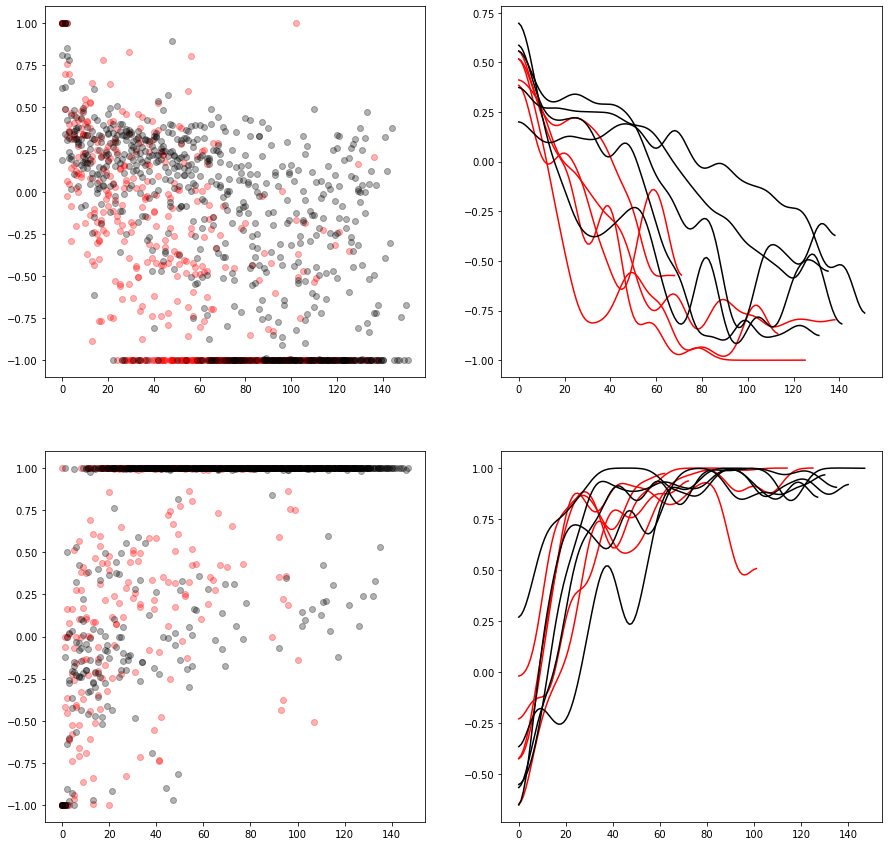

In [28]:
fig,ax = plt.subplots(2,2,figsize=[15,15])

KO_vars = np.zeros([5,3,6])
for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    lr_dp_early = []
    lr_dp_late = []
    for j,d in enumerate(d_list[-3:]):
        if j == 0:
            
            nonbaseline_inds = d['block_number']>=2
            lr_dp_early.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_dp_late.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
        elif j ==1 :
            lr_dp_early.append(d['lickrate_dprime'][(d['LR']==-1)])
            lr_dp_late.append(d['lickrate_dprime'][(d['LR']==1)])
        else:
            nonbaseline_inds = (d['block_number']<2)
            lr_dp_early.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_dp_late.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
            
    lr_dp_early = np.concatenate(lr_dp_early)
    lr_dp_late = np.concatenate(lr_dp_late)

    lr_early_smooth = sp.ndimage.filters.gaussian_filter1d(lr_dp_early, 5)
    lr_late_smooth = sp.ndimage.filters.gaussian_filter1d(lr_dp_late, 5)
    inds_early = np.arange(lr_dp_early.shape[0])
    ax[0,0].scatter(inds_early,lr_dp_early,color='red',alpha=.3)
    ax[0,1].plot(inds_early,lr_early_smooth,color='red')
    
    inds_late = np.arange(lr_dp_late.shape[0])
    ax[1,0].scatter(inds_late,lr_dp_late,color='red',alpha=.3)
    ax[1,1].plot(inds_late,lr_late_smooth,color='red')

for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    lr_dp_early = []
    lr_dp_late = []
    for j,d in enumerate(d_list[-3:]):
        if j == 0:
            
            nonbaseline_inds = d['block_number']>=2
            lr_dp_early.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_dp_late.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
        elif j ==1 :
            lr_dp_early.append(d['lickrate_dprime'][(d['LR']==-1)])
            lr_dp_late.append(d['lickrate_dprime'][(d['LR']==1)])
        else:
            nonbaseline_inds = (d['block_number']<2)
            lr_dp_early.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==-1)])
            lr_dp_late.append(d['lickrate_dprime'][nonbaseline_inds*(d['LR']==1)])
            
    lr_dp_early = np.concatenate(lr_dp_early)
    lr_dp_late = np.concatenate(lr_dp_late)

    lr_early_smooth = sp.ndimage.filters.gaussian_filter1d(lr_dp_early, 5)
    lr_late_smooth = sp.ndimage.filters.gaussian_filter1d(lr_dp_late, 5)
    inds_early = np.arange(lr_dp_early.shape[0])
    ax[0,0].scatter(inds_early,lr_dp_early,color='black',alpha=.3)
    ax[0,1].plot(inds_early,lr_early_smooth,color='black')
    
    inds_late = np.arange(lr_dp_late.shape[0])
    ax[1,0].scatter(inds_late,lr_dp_late,color='black',alpha=.3)
    ax[1,1].plot(inds_late,lr_late_smooth,color='black')


In [ ]:
# omission rate

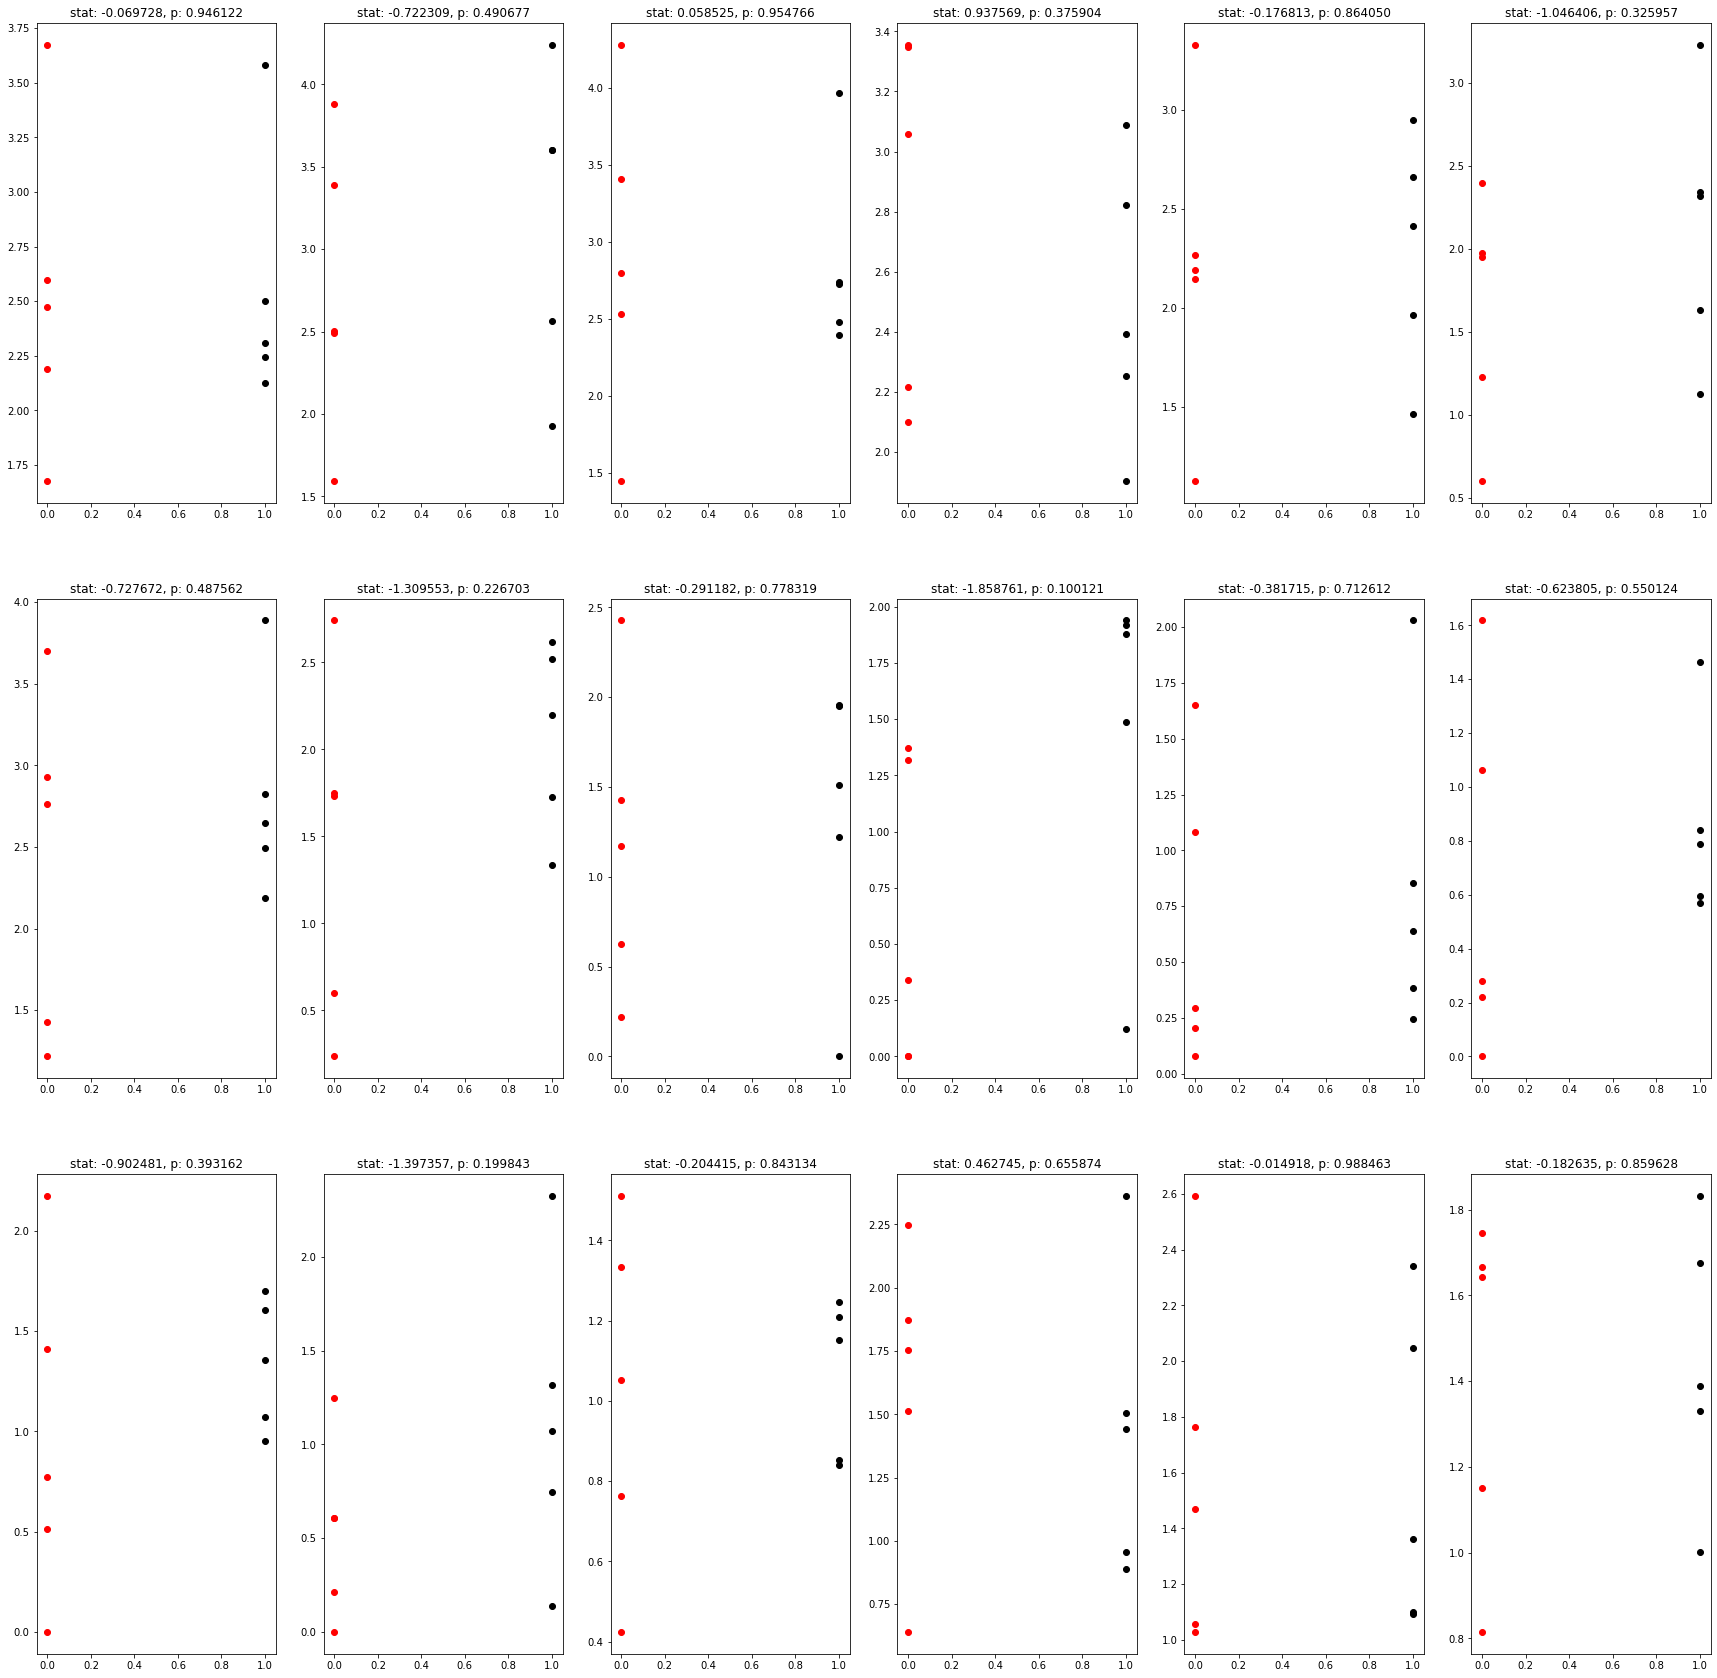

In [31]:
fig,ax = plt.subplots(3,6,figsize=[30,30])

for row in range(3):
    for col in range(6):
        ax[row,col].scatter(np.zeros([5,]), KO_vars[:,row,col],color='red')
        ax[row,col].scatter(np.ones([5,]), CTRL_vars[:,row,col],color='black')
#         stat,p = sp.stats.ranksums(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        stat,p = sp.stats.ttest_ind(KO_vars[:,row,col].ravel() ,CTRL_vars[:,row,col].ravel())
        ax[row,col].set_title("stat: %f, p: %f" % (stat,p))

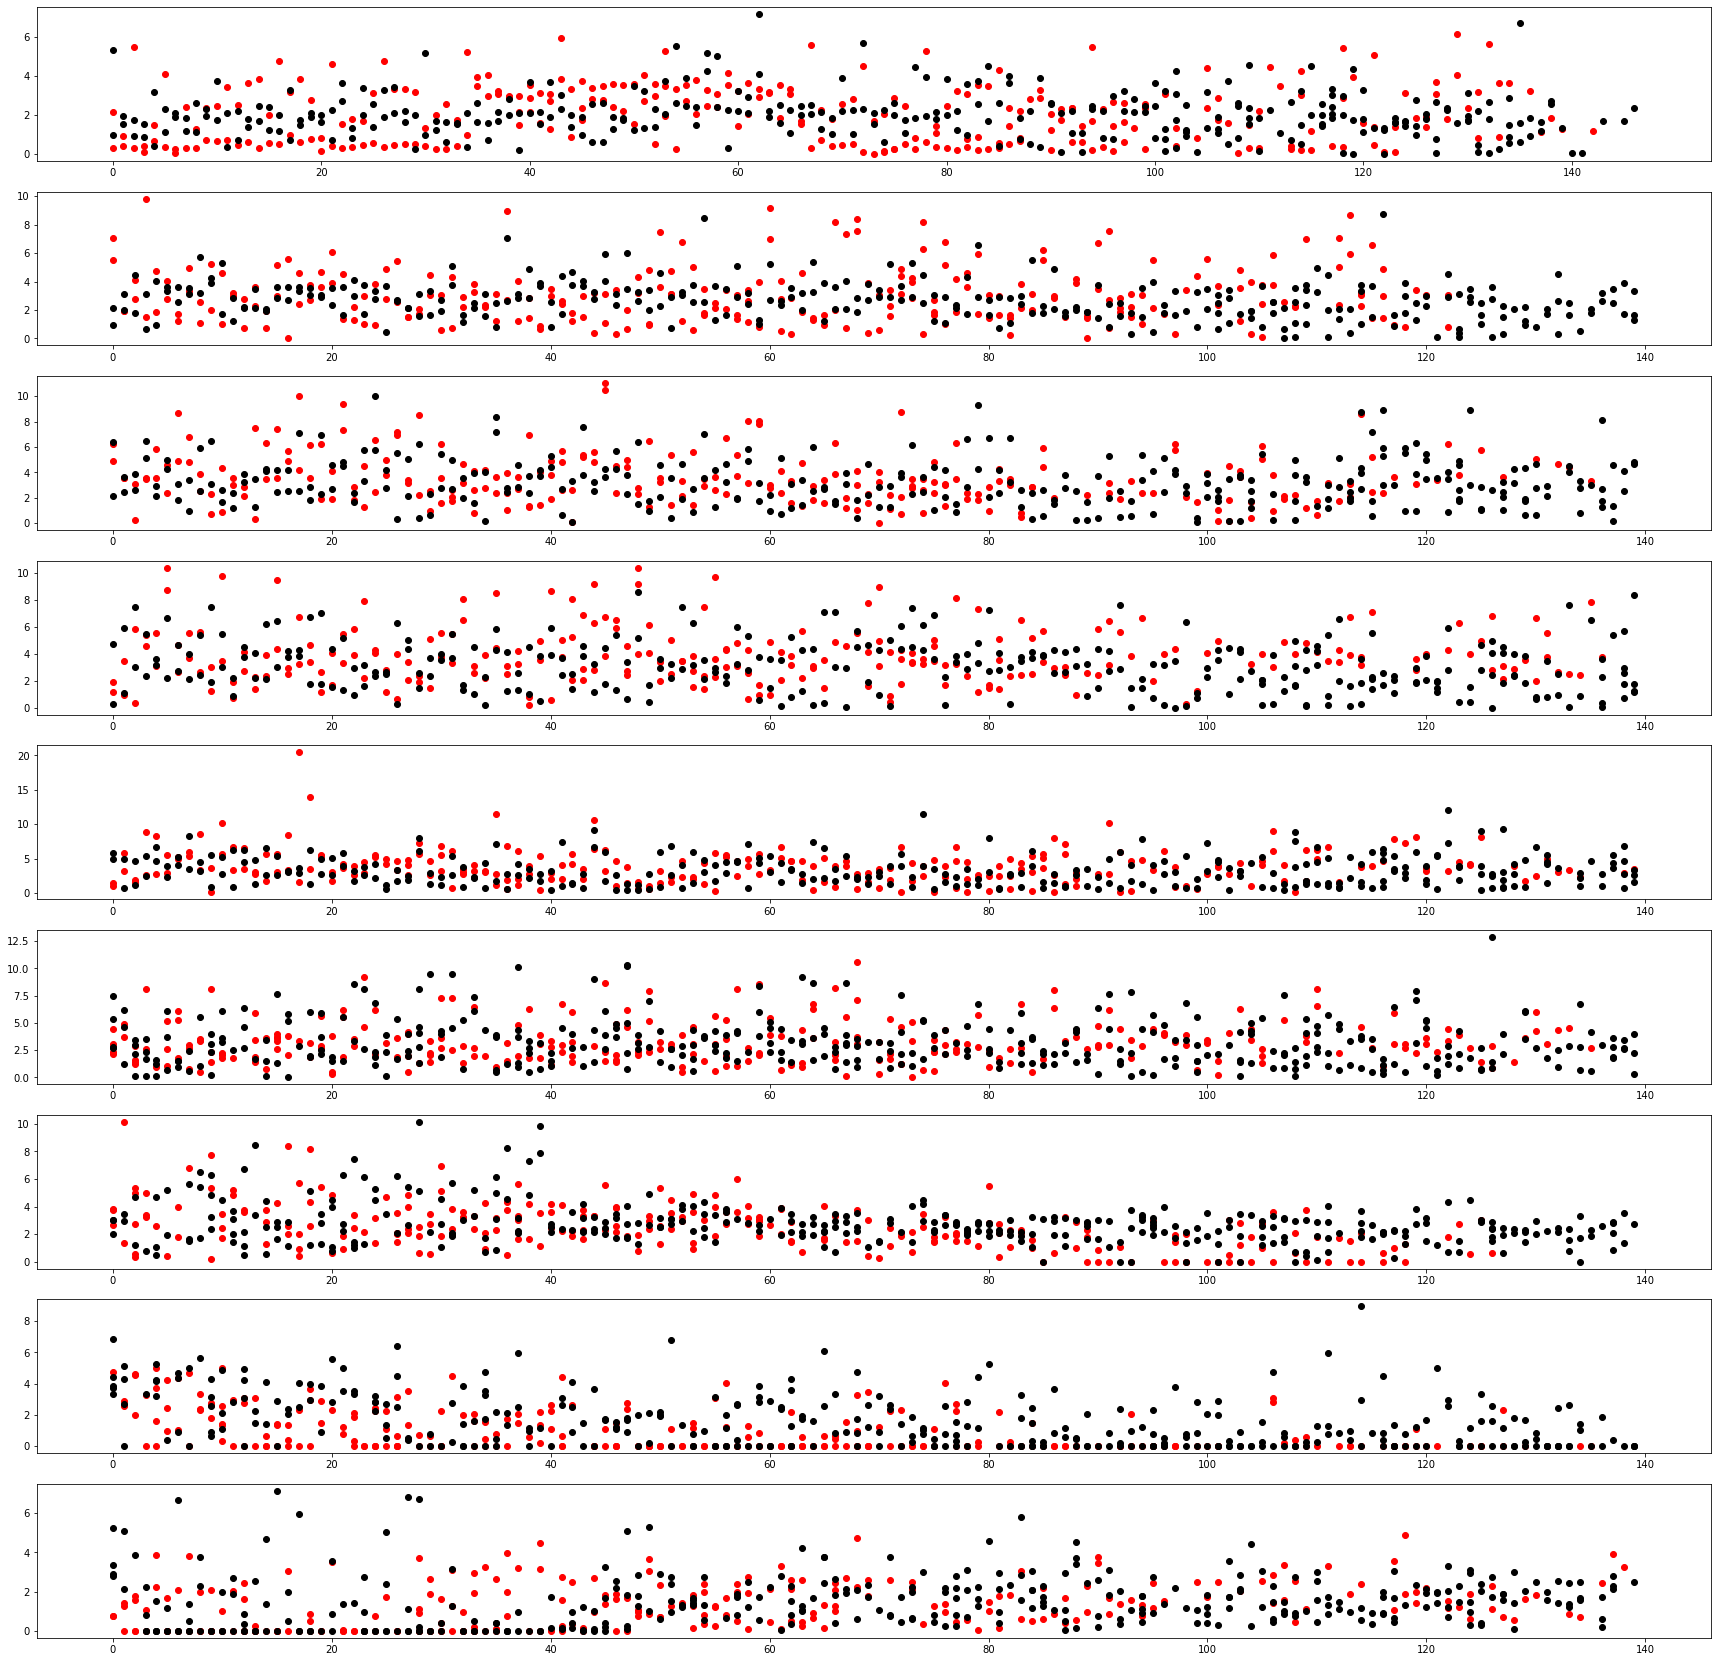

In [32]:
fig,ax = plt.subplots(9,1,figsize=[30,30])

for i, (mouse,d_list) in enumerate(KO_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['LR']==-1],d['lickrate_rz_early'][d['LR']==-1], color = 'red')

for i, (mouse,d_list) in enumerate(CTRL_sessions.items()):
    for j,d in enumerate(d_list[:9]):
        ax[j].scatter(d['trial_number'][d['LR']==-1],d['lickrate_rz_early'][d['LR']==-1], color = 'black')
    